# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [2]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip



!unzip -q data.zip

--2023-12-07 16:05:42--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-07 16:05:42--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  71.8MB/s    in 0.2s    

2023-12-07 16:05:42 (71.8 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [4]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    filename = image_name.split("/")[-1].split(".")[0]
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    bboxes = []
    for member in treeroot.findall("object"):
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        class_label = class_dict[member.find("name").text]

        bboxes.append([xmin, ymin, xmax, ymax, class_label])

    return bboxes


In [5]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(fname).convert("RGB")
        image = np.array(image)
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        transformed = self.transform(image=image, bboxes=bboxes)
        return transformed['image'], transformed['bboxes']

    def __len__(self):
        return len(self.filenames)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

        return bboxes


Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [6]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [7]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [8]:
def visualize(images, bboxes, class_dict_inv):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    num_images = len(images)
    rows = 2
    cols = num_images // 2 + num_images % 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:
            break
        img = images[i].permute(1, 2, 0).numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, class_dict_inv[class_id],
                    bbox=dict(facecolor='yellow', alpha=0.5))

    fig.tight_layout()
    plt.show()



У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

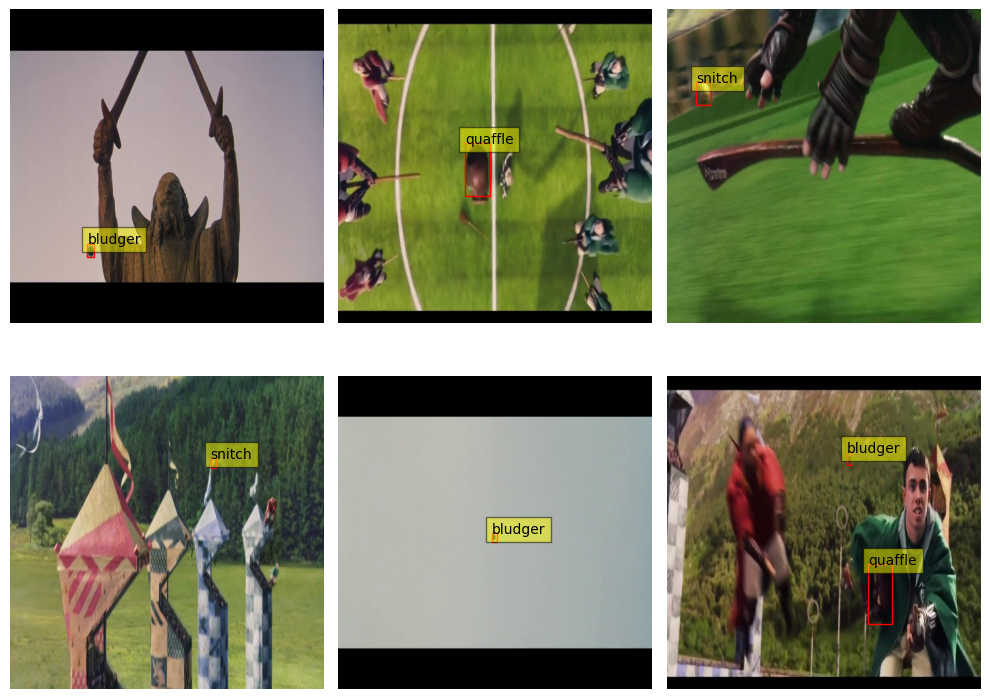

In [9]:

out = [train_ds[i] for i in range(6)]
visualize([o[0] for o in out], [o[1] for o in out], train_ds.class_dict_inv)

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [54]:
def collate_fn(batch, downsample=32):
    imgs = [item[0] for item in batch]
    batch_boxes = [item[1] for item in batch]

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = torch.zeros(b, 5 + num_classes, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        for box in boxes:
            xmin, ymin, xmax, ymax, class_id = box

            w_box = (xmax - xmin) / w
            h_box = (ymax - ymin) / h

            cx = (xmin + xmax) / 2
            cy = (ymin + ymax) / 2
            cx_idx = int(cx // downsample)
            cy_idx = int(cy // downsample)

            cx_box = (cx - cx_idx * downsample) / downsample
            cy_box = (cy - cy_idx * downsample) / downsample
            values = torch.tensor([cx_box, cy_box, w_box, h_box, 1] + [0] * num_classes)
            values[5 + class_id] = 1
            target[i, :, cy_idx, cx_idx] = values

    return {"image": imgs, "target": target}


Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

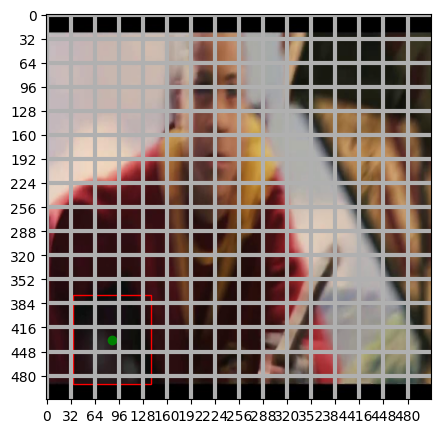

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i][0].permute(1, 2, 0) * torch.tensor(std).view(1, 1, -1) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i][1])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()


## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [76]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    if pred.dim() == 3:
        pred = pred.unsqueeze(0)

    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    decoded_boxes = []
    for i in range(b):
        boxes = []
        for y in range(h):
            for x in range(w):
                conf = pred[i, 4, y, x]

                if conf > threshold:
                    cx_cell, cy_cell, w_box, h_box = pred[i, 0:4, y, x]
                    cx = (cx_cell + x) * upsample
                    cy = (cy_cell + y) * upsample

                    w_box *= img_w
                    h_box *= img_h

                    xmin = cx - w_box / 2
                    ymin = cy - h_box / 2
                    xmax = xmin + w_box
                    ymax = ymin + h_box

                    if c > 6:
                        class_id = torch.argmax(pred[i, 5:, y, x])
                    else:
                        class_id = pred[i, 5, y, x]

                    boxes.append([xmin, ymin, xmax, ymax, class_id])

        decoded_boxes.append(boxes)

    return decoded_boxes


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [77]:


class Detector(nn.Module):
    def __init__(self, num_classes):
        super(Detector, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.feature_extractor = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )

        self.conv_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)
        )

    def forward(self, img):
        x = self.feature_extractor(img)
        x = self.conv_layers(x)
        return torch.sigmoid(x)

num_classes = 3
model = Detector(num_classes=num_classes)


In [78]:
with open('data/class_dict', 'r') as file:
    class_dict = eval(file.readline())

C = len(class_dict)
print("Количество классов в датасете:", C)


Количество классов в датасете: 3


## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [79]:


def special_loss(pred, target, check=False, C=3):
    if pred.shape != target.shape:
        raise ValueError("Prediction and target tensors must have the same shape.")

    object_mask = target[:, 4, :, :] > 0.5
    object_mask_unsqueezed = object_mask.unsqueeze(1).expand_as(target[:, 0:2, :, :])

    localization_loss = F.mse_loss(pred[:, 0:2, :, :][object_mask_unsqueezed], target[:, 0:2, :, :][object_mask_unsqueezed], reduction='sum')

    pred_wh = torch.sqrt(pred[:, 2:4, :, :][object_mask_unsqueezed] + 1e-16)
    target_wh = torch.sqrt(target[:, 2:4, :, :][object_mask_unsqueezed])
    box_loss = F.mse_loss(pred_wh, target_wh, reduction='sum')

    classification_loss = F.cross_entropy(pred[:, 5:(5 + C), :, :].permute(0, 2, 3, 1)[object_mask], target[:, 5, :, :][object_mask].long(), reduction='sum')

    confidence_loss = F.binary_cross_entropy(pred[:, 4, :, :], target[:, 4, :, :], reduction='sum') * 0.1

    print("Localization Loss:", localization_loss.item())
    print("Box Loss:", box_loss.item())
    print("Classification Loss:", classification_loss.item())
    print("Confidence Loss:", confidence_loss.item())

    total_loss = localization_loss + box_loss + classification_loss + confidence_loss

    if not check:
        return total_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss


In [80]:
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(25600.))


Localization Loss: 5120.0
Box Loss: 5120.0
Classification Loss: 2812.446533203125
Confidence Loss: 25600.0


RuntimeError: ignored

Результаты функции потерь: (tensor(61.7344), tensor(80.6964), tensor(88.9876), tensor(6277.2358))


# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [81]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(21)
EPOCHS = 20
num_classes = 3
model = Detector(num_classes=num_classes).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['target'].to(device)

        opt.zero_grad()
        outputs = model(images)

        if outputs.shape != targets.shape:
            print(f"Shape mismatch: Output shape {outputs.shape}, Target shape {targets.shape}")
            continue

        loss = special_loss(outputs, targets)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")


  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 2.43294095993042
Box Loss: 4.44481086730957
Classification Loss: 11.889108657836914
Confidence Loss: 198.3663787841797



  3%|▎         | 1/29 [00:00<00:22,  1.25it/s]

Localization Loss: 1.6139273643493652
Box Loss: 1.8137508630752563
Classification Loss: 11.527427673339844
Confidence Loss: 174.141357421875



  7%|▋         | 2/29 [00:01<00:17,  1.53it/s]

Localization Loss: 1.9515373706817627
Box Loss: 3.2712626457214355
Classification Loss: 12.65856647491455
Confidence Loss: 145.9546661376953



 10%|█         | 3/29 [00:01<00:15,  1.63it/s]

Localization Loss: 1.8961745500564575
Box Loss: 2.0234827995300293
Classification Loss: 11.371252059936523
Confidence Loss: 126.1729965209961



 14%|█▍        | 4/29 [00:02<00:14,  1.69it/s]

Localization Loss: 0.9429876208305359
Box Loss: 2.0044069290161133
Classification Loss: 9.992918968200684
Confidence Loss: 112.63018035888672



 17%|█▋        | 5/29 [00:03<00:13,  1.72it/s]

Localization Loss: 1.8994033336639404
Box Loss: 1.813085675239563
Classification Loss: 12.527321815490723
Confidence Loss: 103.00516510009766



 21%|██        | 6/29 [00:03<00:13,  1.75it/s]

Localization Loss: 1.2517387866973877
Box Loss: 0.942006528377533
Classification Loss: 10.398487091064453
Confidence Loss: 93.56554412841797



 24%|██▍       | 7/29 [00:04<00:12,  1.77it/s]

Localization Loss: 1.1024380922317505
Box Loss: 1.4990483522415161
Classification Loss: 11.320465087890625
Confidence Loss: 85.26702880859375



 28%|██▊       | 8/29 [00:04<00:11,  1.77it/s]

Localization Loss: 2.046773910522461
Box Loss: 1.5813360214233398
Classification Loss: 9.620003700256348
Confidence Loss: 77.37622833251953



 31%|███       | 9/29 [00:05<00:11,  1.79it/s]

Localization Loss: 1.128351092338562
Box Loss: 0.6785365343093872
Classification Loss: 9.26216983795166
Confidence Loss: 71.82078552246094



 34%|███▍      | 10/29 [00:05<00:10,  1.80it/s]

Localization Loss: 1.6810005903244019
Box Loss: 0.8332700133323669
Classification Loss: 10.183804512023926
Confidence Loss: 65.70836639404297



 38%|███▊      | 11/29 [00:06<00:10,  1.76it/s]

Localization Loss: 1.505530834197998
Box Loss: 0.6210450530052185
Classification Loss: 10.669622421264648
Confidence Loss: 60.85543441772461



 41%|████▏     | 12/29 [00:07<00:09,  1.72it/s]

Localization Loss: 0.851872444152832
Box Loss: 0.19378235936164856
Classification Loss: 8.559896469116211
Confidence Loss: 55.50236892700195



 45%|████▍     | 13/29 [00:07<00:09,  1.70it/s]

Localization Loss: 1.8870782852172852
Box Loss: 0.6718538999557495
Classification Loss: 11.012468338012695
Confidence Loss: 52.28629684448242



 48%|████▊     | 14/29 [00:08<00:08,  1.71it/s]

Localization Loss: 1.1683896780014038
Box Loss: 0.31259238719940186
Classification Loss: 9.25695514678955
Confidence Loss: 47.80225372314453



 52%|█████▏    | 15/29 [00:08<00:08,  1.67it/s]

Localization Loss: 1.5206235647201538
Box Loss: 0.46115559339523315
Classification Loss: 11.499590873718262
Confidence Loss: 43.88923263549805



 55%|█████▌    | 16/29 [00:09<00:07,  1.65it/s]

Localization Loss: 1.3602112531661987
Box Loss: 0.3193744421005249
Classification Loss: 11.550740242004395
Confidence Loss: 40.89057159423828



 59%|█████▊    | 17/29 [00:09<00:07,  1.70it/s]

Localization Loss: 1.0039738416671753
Box Loss: 0.14396272599697113
Classification Loss: 9.213068008422852
Confidence Loss: 37.81440353393555



 62%|██████▏   | 18/29 [00:10<00:06,  1.73it/s]

Localization Loss: 0.8503303527832031
Box Loss: 0.15776093304157257
Classification Loss: 8.126240730285645
Confidence Loss: 34.41848373413086



 66%|██████▌   | 19/29 [00:11<00:05,  1.76it/s]

Localization Loss: 1.3894120454788208
Box Loss: 0.4545045495033264
Classification Loss: 9.277571678161621
Confidence Loss: 32.079078674316406



 69%|██████▉   | 20/29 [00:11<00:05,  1.77it/s]

Localization Loss: 1.006731629371643
Box Loss: 0.19143038988113403
Classification Loss: 9.530427932739258
Confidence Loss: 29.99714469909668



 72%|███████▏  | 21/29 [00:12<00:04,  1.78it/s]

Localization Loss: 0.8385879993438721
Box Loss: 0.23841333389282227
Classification Loss: 8.383724212646484
Confidence Loss: 27.700698852539062



 76%|███████▌  | 22/29 [00:12<00:03,  1.79it/s]

Localization Loss: 1.6721371412277222
Box Loss: 0.7574256658554077
Classification Loss: 8.3146333694458
Confidence Loss: 25.944135665893555



 79%|███████▉  | 23/29 [00:13<00:03,  1.80it/s]

Localization Loss: 1.0772974491119385
Box Loss: 0.180064857006073
Classification Loss: 9.021136283874512
Confidence Loss: 24.2117862701416



 83%|████████▎ | 24/29 [00:13<00:02,  1.79it/s]

Localization Loss: 1.1415989398956299
Box Loss: 0.22276705503463745
Classification Loss: 8.876083374023438
Confidence Loss: 22.627017974853516



 86%|████████▌ | 25/29 [00:14<00:02,  1.79it/s]

Localization Loss: 1.169252634048462
Box Loss: 0.17940473556518555
Classification Loss: 7.469607830047607
Confidence Loss: 21.468830108642578



 90%|████████▉ | 26/29 [00:14<00:01,  1.80it/s]

Localization Loss: 1.398092269897461
Box Loss: 0.11621510982513428
Classification Loss: 7.113796234130859
Confidence Loss: 19.886287689208984



 93%|█████████▎| 27/29 [00:15<00:01,  1.80it/s]

Localization Loss: 0.8066809177398682
Box Loss: 0.09644343703985214
Classification Loss: 7.163503170013428
Confidence Loss: 18.766271591186523



  5%|▌         | 1/20 [00:16<05:09, 16.31s/it]

Localization Loss: 0.8215519189834595
Box Loss: 0.02338547259569168
Classification Loss: 1.8340342044830322
Confidence Loss: 5.238105773925781
Epoch 0 done; Train loss 75.816;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.9065011739730835
Box Loss: 0.3245837986469269
Classification Loss: 8.210797309875488
Confidence Loss: 17.47684097290039



  3%|▎         | 1/29 [00:00<00:15,  1.77it/s]

Localization Loss: 0.8956270813941956
Box Loss: 0.304697722196579
Classification Loss: 9.236349105834961
Confidence Loss: 16.3355655670166



  7%|▋         | 2/29 [00:01<00:15,  1.78it/s]

Localization Loss: 1.246382236480713
Box Loss: 0.38185828924179077
Classification Loss: 8.813360214233398
Confidence Loss: 15.646371841430664



 10%|█         | 3/29 [00:01<00:14,  1.78it/s]

Localization Loss: 0.7641919255256653
Box Loss: 0.1700226366519928
Classification Loss: 7.659716606140137
Confidence Loss: 14.717940330505371



 14%|█▍        | 4/29 [00:02<00:14,  1.78it/s]

Localization Loss: 0.5616517066955566
Box Loss: 0.14128610491752625
Classification Loss: 6.64124059677124
Confidence Loss: 13.687089920043945



 17%|█▋        | 5/29 [00:02<00:13,  1.77it/s]

Localization Loss: 1.4352777004241943
Box Loss: 0.3514009714126587
Classification Loss: 7.973354816436768
Confidence Loss: 13.766934394836426



 21%|██        | 6/29 [00:03<00:13,  1.77it/s]

Localization Loss: 0.7083811163902283
Box Loss: 0.38652747869491577
Classification Loss: 7.732174873352051
Confidence Loss: 13.206718444824219



 24%|██▍       | 7/29 [00:03<00:12,  1.74it/s]

Localization Loss: 0.49846136569976807
Box Loss: 0.29154568910598755
Classification Loss: 8.382034301757812
Confidence Loss: 12.624798774719238



 28%|██▊       | 8/29 [00:04<00:12,  1.70it/s]

Localization Loss: 1.1331751346588135
Box Loss: 0.09332849085330963
Classification Loss: 6.148189067840576
Confidence Loss: 11.828234672546387



 31%|███       | 9/29 [00:05<00:11,  1.70it/s]

Localization Loss: 0.7612137794494629
Box Loss: 0.12606263160705566
Classification Loss: 6.251823425292969
Confidence Loss: 11.29139232635498



 34%|███▍      | 10/29 [00:05<00:11,  1.70it/s]

Localization Loss: 1.0114909410476685
Box Loss: 0.12509924173355103
Classification Loss: 7.077729225158691
Confidence Loss: 11.34939956665039



 38%|███▊      | 11/29 [00:06<00:10,  1.70it/s]

Localization Loss: 0.9776114821434021
Box Loss: 0.12862861156463623
Classification Loss: 7.32014799118042
Confidence Loss: 10.82353687286377



 41%|████▏     | 12/29 [00:06<00:10,  1.69it/s]

Localization Loss: 0.3802483081817627
Box Loss: 0.09315390884876251
Classification Loss: 5.950204849243164
Confidence Loss: 10.052505493164062



 45%|████▍     | 13/29 [00:07<00:09,  1.71it/s]

Localization Loss: 1.1243414878845215
Box Loss: 0.6842846274375916
Classification Loss: 7.5581512451171875
Confidence Loss: 10.411401748657227



 48%|████▊     | 14/29 [00:08<00:08,  1.74it/s]

Localization Loss: 0.8652504682540894
Box Loss: 0.29792773723602295
Classification Loss: 6.768660068511963
Confidence Loss: 9.848292350769043



 52%|█████▏    | 15/29 [00:08<00:08,  1.74it/s]

Localization Loss: 0.592138409614563
Box Loss: 0.5188626646995544
Classification Loss: 9.140375137329102
Confidence Loss: 9.520873069763184



 55%|█████▌    | 16/29 [00:09<00:07,  1.74it/s]

Localization Loss: 0.6835817098617554
Box Loss: 0.16167840361595154
Classification Loss: 8.657037734985352
Confidence Loss: 9.967692375183105



 59%|█████▊    | 17/29 [00:09<00:06,  1.76it/s]

Localization Loss: 0.4821534752845764
Box Loss: 0.1382637917995453
Classification Loss: 6.732672691345215
Confidence Loss: 8.75037670135498



 62%|██████▏   | 18/29 [00:10<00:06,  1.77it/s]

Localization Loss: 0.8242758512496948
Box Loss: 0.0881166160106659
Classification Loss: 6.086472034454346
Confidence Loss: 8.318883895874023



 66%|██████▌   | 19/29 [00:10<00:05,  1.79it/s]

Localization Loss: 0.6607277989387512
Box Loss: 0.2279919981956482
Classification Loss: 7.1430583000183105
Confidence Loss: 8.53693675994873



 69%|██████▉   | 20/29 [00:11<00:05,  1.78it/s]

Localization Loss: 0.4407949447631836
Box Loss: 0.15052253007888794
Classification Loss: 6.988088130950928
Confidence Loss: 8.353240013122559



 72%|███████▏  | 21/29 [00:11<00:04,  1.79it/s]

Localization Loss: 0.4005506634712219
Box Loss: 0.12976717948913574
Classification Loss: 6.3628692626953125
Confidence Loss: 7.850687503814697



 76%|███████▌  | 22/29 [00:12<00:03,  1.79it/s]

Localization Loss: 0.865960955619812
Box Loss: 0.5224494338035583
Classification Loss: 6.199286460876465
Confidence Loss: 8.168450355529785



 79%|███████▉  | 23/29 [00:13<00:03,  1.80it/s]

Localization Loss: 0.19665201008319855
Box Loss: 0.11788104474544525
Classification Loss: 6.78223180770874
Confidence Loss: 7.203698635101318



 83%|████████▎ | 24/29 [00:13<00:02,  1.79it/s]

Localization Loss: 0.6017895936965942
Box Loss: 0.2824877202510834
Classification Loss: 6.919305801391602
Confidence Loss: 7.61074161529541



 86%|████████▌ | 25/29 [00:14<00:02,  1.78it/s]

Localization Loss: 0.6557852029800415
Box Loss: 0.16767661273479462
Classification Loss: 6.497342109680176
Confidence Loss: 7.455407619476318



 90%|████████▉ | 26/29 [00:14<00:01,  1.79it/s]

Localization Loss: 0.47865962982177734
Box Loss: 0.1391974538564682
Classification Loss: 5.717008113861084
Confidence Loss: 6.825741767883301



 93%|█████████▎| 27/29 [00:15<00:01,  1.80it/s]

Localization Loss: 0.3922804594039917
Box Loss: 0.07660476863384247
Classification Loss: 5.835666656494141
Confidence Loss: 6.197906494140625



 10%|█         | 2/20 [00:32<04:51, 16.20s/it]

Localization Loss: 0.19125083088874817
Box Loss: 0.01554667018353939
Classification Loss: 1.7379932403564453
Confidence Loss: 1.8808517456054688
Epoch 1 done; Train loss 18.262;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.3428114354610443
Box Loss: 0.10824112594127655
Classification Loss: 6.47285270690918
Confidence Loss: 6.257339000701904



  3%|▎         | 1/29 [00:00<00:16,  1.72it/s]

Localization Loss: 0.7688277959823608
Box Loss: 0.19225642085075378
Classification Loss: 6.659430503845215
Confidence Loss: 6.3296709060668945



  7%|▋         | 2/29 [00:01<00:16,  1.66it/s]

Localization Loss: 0.6393131017684937
Box Loss: 0.11660201847553253
Classification Loss: 7.555475234985352
Confidence Loss: 6.309910297393799



 10%|█         | 3/29 [00:01<00:15,  1.66it/s]

Localization Loss: 0.43658822774887085
Box Loss: 0.15772342681884766
Classification Loss: 6.229551315307617
Confidence Loss: 5.90844202041626



 14%|█▍        | 4/29 [00:02<00:15,  1.64it/s]

Localization Loss: 0.3751813769340515
Box Loss: 0.06553855538368225
Classification Loss: 5.604279041290283
Confidence Loss: 5.380331039428711



 17%|█▋        | 5/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.997382402420044
Box Loss: 0.17995193600654602
Classification Loss: 7.5080790519714355
Confidence Loss: 6.2365922927856445



 21%|██        | 6/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.4424947500228882
Box Loss: 0.17159366607666016
Classification Loss: 6.273289203643799
Confidence Loss: 6.289315223693848



 24%|██▍       | 7/29 [00:04<00:13,  1.63it/s]

Localization Loss: 0.5626022815704346
Box Loss: 0.3887631297111511
Classification Loss: 7.536787986755371
Confidence Loss: 6.642983436584473



 28%|██▊       | 8/29 [00:04<00:12,  1.63it/s]

Localization Loss: 0.4110521972179413
Box Loss: 0.06626519560813904
Classification Loss: 5.668391227722168
Confidence Loss: 5.434300899505615



 31%|███       | 9/29 [00:05<00:11,  1.67it/s]

Localization Loss: 0.48365142941474915
Box Loss: 0.06080028414726257
Classification Loss: 5.900130748748779
Confidence Loss: 5.173593044281006



 34%|███▍      | 10/29 [00:06<00:11,  1.70it/s]

Localization Loss: 0.6102144718170166
Box Loss: 0.06653691828250885
Classification Loss: 6.3313822746276855
Confidence Loss: 5.717324733734131



 38%|███▊      | 11/29 [00:06<00:10,  1.72it/s]

Localization Loss: 0.5733703374862671
Box Loss: 0.12043541669845581
Classification Loss: 6.258028030395508
Confidence Loss: 5.350241661071777



 41%|████▏     | 12/29 [00:07<00:09,  1.72it/s]

Localization Loss: 0.26628410816192627
Box Loss: 0.04358743131160736
Classification Loss: 5.637556076049805
Confidence Loss: 5.065621376037598



 45%|████▍     | 13/29 [00:07<00:09,  1.74it/s]

Localization Loss: 0.8056074380874634
Box Loss: 0.42677614092826843
Classification Loss: 6.858765602111816
Confidence Loss: 5.334552764892578



 48%|████▊     | 14/29 [00:08<00:08,  1.75it/s]

Localization Loss: 0.593972384929657
Box Loss: 0.1779547929763794
Classification Loss: 6.467290878295898
Confidence Loss: 5.427234172821045



 52%|█████▏    | 15/29 [00:08<00:08,  1.73it/s]

Localization Loss: 0.5383102297782898
Box Loss: 0.3123983144760132
Classification Loss: 7.329461097717285
Confidence Loss: 4.9481706619262695



 55%|█████▌    | 16/29 [00:09<00:07,  1.73it/s]

Localization Loss: 0.5311965942382812
Box Loss: 0.12547676265239716
Classification Loss: 8.115219116210938
Confidence Loss: 5.661169528961182



 59%|█████▊    | 17/29 [00:10<00:06,  1.73it/s]

Localization Loss: 0.26126620173454285
Box Loss: 0.07747389376163483
Classification Loss: 6.206198692321777
Confidence Loss: 4.589511871337891



 62%|██████▏   | 18/29 [00:10<00:06,  1.75it/s]

Localization Loss: 0.3561238944530487
Box Loss: 0.07344143092632294
Classification Loss: 5.591688632965088
Confidence Loss: 4.18987512588501



 66%|██████▌   | 19/29 [00:11<00:05,  1.76it/s]

Localization Loss: 0.5877057313919067
Box Loss: 0.1345081925392151
Classification Loss: 6.86822509765625
Confidence Loss: 5.064861297607422



 69%|██████▉   | 20/29 [00:11<00:05,  1.76it/s]

Localization Loss: 0.6130248308181763
Box Loss: 0.054428499191999435
Classification Loss: 6.703221797943115
Confidence Loss: 4.220414161682129



 72%|███████▏  | 21/29 [00:12<00:04,  1.76it/s]

Localization Loss: 0.2445846050977707
Box Loss: 0.06567203253507614
Classification Loss: 6.250500679016113
Confidence Loss: 4.204299449920654



 76%|███████▌  | 22/29 [00:12<00:03,  1.76it/s]

Localization Loss: 0.9631643295288086
Box Loss: 0.23547382652759552
Classification Loss: 5.690341472625732
Confidence Loss: 4.708024501800537



 79%|███████▉  | 23/29 [00:13<00:03,  1.76it/s]

Localization Loss: 0.5299246907234192
Box Loss: 0.07374592870473862
Classification Loss: 6.727199554443359
Confidence Loss: 4.293580055236816



 83%|████████▎ | 24/29 [00:13<00:02,  1.75it/s]

Localization Loss: 0.6659127473831177
Box Loss: 0.19711312651634216
Classification Loss: 6.538642883300781
Confidence Loss: 4.312951564788818



 86%|████████▌ | 25/29 [00:14<00:02,  1.75it/s]

Localization Loss: 0.5471988916397095
Box Loss: 0.10155642032623291
Classification Loss: 6.141254901885986
Confidence Loss: 4.381251811981201



 90%|████████▉ | 26/29 [00:15<00:01,  1.72it/s]

Localization Loss: 0.36057084798812866
Box Loss: 0.07274320721626282
Classification Loss: 5.587620735168457
Confidence Loss: 3.755030870437622



 93%|█████████▎| 27/29 [00:15<00:01,  1.67it/s]

Localization Loss: 0.32506901025772095
Box Loss: 0.07718808948993683
Classification Loss: 5.59021520614624
Confidence Loss: 3.990550994873047



 15%|█▌        | 3/20 [00:49<04:39, 16.42s/it]

Localization Loss: 0.2646242082118988
Box Loss: 0.01619037613272667
Classification Loss: 1.6824830770492554
Confidence Loss: 1.2403125762939453
Epoch 2 done; Train loss 11.981;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.3961661458015442
Box Loss: 0.0956660658121109
Classification Loss: 6.567044258117676
Confidence Loss: 3.619824171066284



  3%|▎         | 1/29 [00:00<00:17,  1.56it/s]

Localization Loss: 0.43418365716934204
Box Loss: 0.12771287560462952
Classification Loss: 6.264853000640869
Confidence Loss: 3.475271224975586



  7%|▋         | 2/29 [00:01<00:17,  1.56it/s]

Localization Loss: 0.3020217716693878
Box Loss: 0.0891297459602356
Classification Loss: 6.85237455368042
Confidence Loss: 3.900963544845581



 10%|█         | 3/29 [00:01<00:16,  1.58it/s]

Localization Loss: 0.3784122169017792
Box Loss: 0.08694354444742203
Classification Loss: 6.3179802894592285
Confidence Loss: 3.4438698291778564



 14%|█▍        | 4/29 [00:02<00:15,  1.61it/s]

Localization Loss: 0.21023058891296387
Box Loss: 0.07138048112392426
Classification Loss: 5.624958515167236
Confidence Loss: 3.0152111053466797



 17%|█▋        | 5/29 [00:03<00:14,  1.65it/s]

Localization Loss: 0.6953907012939453
Box Loss: 0.16349488496780396
Classification Loss: 7.136791229248047
Confidence Loss: 5.111668109893799



 21%|██        | 6/29 [00:03<00:13,  1.67it/s]

Localization Loss: 0.2350589632987976
Box Loss: 0.10467523336410522
Classification Loss: 6.248433589935303
Confidence Loss: 3.584747314453125



 24%|██▍       | 7/29 [00:04<00:12,  1.70it/s]

Localization Loss: 0.2967028021812439
Box Loss: 0.24189415574073792
Classification Loss: 8.75354290008545
Confidence Loss: 4.635933876037598



 28%|██▊       | 8/29 [00:04<00:12,  1.70it/s]

Localization Loss: 0.41831713914871216
Box Loss: 0.07871582359075546
Classification Loss: 5.551687240600586
Confidence Loss: 3.072697401046753



 31%|███       | 9/29 [00:05<00:11,  1.72it/s]

Localization Loss: 0.5359287261962891
Box Loss: 0.06166636198759079
Classification Loss: 5.557584762573242
Confidence Loss: 3.1088955402374268



 34%|███▍      | 10/29 [00:05<00:10,  1.74it/s]

Localization Loss: 0.5631558895111084
Box Loss: 0.11456310749053955
Classification Loss: 6.167536735534668
Confidence Loss: 3.587942600250244



 38%|███▊      | 11/29 [00:06<00:10,  1.73it/s]

Localization Loss: 0.313703328371048
Box Loss: 0.08061285316944122
Classification Loss: 6.444953918457031
Confidence Loss: 3.262575149536133



 41%|████▏     | 12/29 [00:07<00:09,  1.73it/s]

Localization Loss: 0.3074982464313507
Box Loss: 0.034738823771476746
Classification Loss: 5.549901008605957
Confidence Loss: 2.912631034851074



 45%|████▍     | 13/29 [00:07<00:09,  1.74it/s]

Localization Loss: 0.8592662811279297
Box Loss: 0.33080875873565674
Classification Loss: 7.100020408630371
Confidence Loss: 3.867029905319214



 48%|████▊     | 14/29 [00:08<00:08,  1.74it/s]

Localization Loss: 0.5827111601829529
Box Loss: 0.0811326652765274
Classification Loss: 6.279703140258789
Confidence Loss: 3.4274215698242188



 52%|█████▏    | 15/29 [00:08<00:08,  1.72it/s]

Localization Loss: 0.5033701062202454
Box Loss: 0.13994552195072174
Classification Loss: 7.24793815612793
Confidence Loss: 3.4083900451660156



 55%|█████▌    | 16/29 [00:09<00:07,  1.71it/s]

Localization Loss: 1.3656680583953857
Box Loss: 0.18050223588943481
Classification Loss: 7.893916130065918
Confidence Loss: 3.4220921993255615



 59%|█████▊    | 17/29 [00:10<00:06,  1.72it/s]

Localization Loss: 0.4392300844192505
Box Loss: 0.04290223866701126
Classification Loss: 6.103881359100342
Confidence Loss: 3.0362181663513184



 62%|██████▏   | 18/29 [00:10<00:06,  1.72it/s]

Localization Loss: 0.32730066776275635
Box Loss: 0.051060959696769714
Classification Loss: 5.570697784423828
Confidence Loss: 2.86954665184021



 66%|██████▌   | 19/29 [00:11<00:05,  1.73it/s]

Localization Loss: 0.6603325009346008
Box Loss: 0.08682871609926224
Classification Loss: 6.660745143890381
Confidence Loss: 3.054598569869995



 69%|██████▉   | 20/29 [00:11<00:05,  1.72it/s]

Localization Loss: 0.7767282724380493
Box Loss: 0.051871225237846375
Classification Loss: 6.669009208679199
Confidence Loss: 2.8354716300964355



 72%|███████▏  | 21/29 [00:12<00:04,  1.69it/s]

Localization Loss: 0.8477926254272461
Box Loss: 0.05251908302307129
Classification Loss: 6.156021595001221
Confidence Loss: 2.622763156890869



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.6849552989006042
Box Loss: 0.19364452362060547
Classification Loss: 5.636205673217773
Confidence Loss: 3.9286630153656006



 79%|███████▉  | 23/29 [00:13<00:03,  1.63it/s]

Localization Loss: 0.5923388004302979
Box Loss: 0.02830623649060726
Classification Loss: 6.707548141479492
Confidence Loss: 2.606429100036621



 83%|████████▎ | 24/29 [00:14<00:03,  1.60it/s]

Localization Loss: 0.5380690693855286
Box Loss: 0.06935016065835953
Classification Loss: 6.375766277313232
Confidence Loss: 3.261873722076416



 86%|████████▌ | 25/29 [00:14<00:02,  1.60it/s]

Localization Loss: 1.033991813659668
Box Loss: 0.07685993611812592
Classification Loss: 6.1911773681640625
Confidence Loss: 3.400103807449341



 90%|████████▉ | 26/29 [00:15<00:01,  1.60it/s]

Localization Loss: 1.2366441488265991
Box Loss: 0.0461115688085556
Classification Loss: 5.553177833557129
Confidence Loss: 2.7730016708374023



 93%|█████████▎| 27/29 [00:16<00:01,  1.63it/s]

Localization Loss: 0.49020296335220337
Box Loss: 0.043783340603113174
Classification Loss: 5.602847099304199
Confidence Loss: 3.2676517963409424



 20%|██        | 4/20 [01:06<04:26, 16.63s/it]

Localization Loss: 0.48238855600357056
Box Loss: 0.002455631736665964
Classification Loss: 1.6768373250961304
Confidence Loss: 0.6398574113845825
Epoch 3 done; Train loss 10.171;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.455152690410614
Box Loss: 0.09940250217914581
Classification Loss: 6.094843864440918
Confidence Loss: 2.773108720779419



  3%|▎         | 1/29 [00:00<00:16,  1.66it/s]

Localization Loss: 0.566494345664978
Box Loss: 0.06874197721481323
Classification Loss: 6.852004051208496
Confidence Loss: 2.5187690258026123



  7%|▋         | 2/29 [00:01<00:16,  1.68it/s]

Localization Loss: 0.3815420866012573
Box Loss: 0.09723047912120819
Classification Loss: 6.676605224609375
Confidence Loss: 2.9694063663482666



 10%|█         | 3/29 [00:01<00:15,  1.68it/s]

Localization Loss: 1.2051701545715332
Box Loss: 0.05893595144152641
Classification Loss: 6.127529144287109
Confidence Loss: 3.0461816787719727



 14%|█▍        | 4/29 [00:02<00:14,  1.68it/s]

Localization Loss: 0.604049801826477
Box Loss: 0.039003003388643265
Classification Loss: 5.812820911407471
Confidence Loss: 2.904526472091675



 17%|█▋        | 5/29 [00:02<00:14,  1.67it/s]

Localization Loss: 1.0295860767364502
Box Loss: 0.14445921778678894
Classification Loss: 7.020090103149414
Confidence Loss: 3.6294121742248535



 21%|██        | 6/29 [00:03<00:13,  1.68it/s]

Localization Loss: 0.45654866099357605
Box Loss: 0.10158724337816238
Classification Loss: 6.15562105178833
Confidence Loss: 3.164167881011963



 24%|██▍       | 7/29 [00:04<00:13,  1.69it/s]

Localization Loss: 0.2865521311759949
Box Loss: 0.16934257745742798
Classification Loss: 7.297375679016113
Confidence Loss: 3.4741227626800537



 28%|██▊       | 8/29 [00:04<00:12,  1.67it/s]

Localization Loss: 0.6413389444351196
Box Loss: 0.017427921295166016
Classification Loss: 5.687703609466553
Confidence Loss: 2.3866310119628906



 31%|███       | 9/29 [00:05<00:11,  1.68it/s]

Localization Loss: 0.9069762229919434
Box Loss: 0.09835399687290192
Classification Loss: 5.5756378173828125
Confidence Loss: 2.8360164165496826



 34%|███▍      | 10/29 [00:05<00:11,  1.69it/s]

Localization Loss: 0.7732582092285156
Box Loss: 0.15842002630233765
Classification Loss: 6.273409366607666
Confidence Loss: 4.001293182373047



 38%|███▊      | 11/29 [00:06<00:10,  1.70it/s]

Localization Loss: 0.6682328581809998
Box Loss: 0.07222054898738861
Classification Loss: 6.192747116088867
Confidence Loss: 2.7932209968566895



 41%|████▏     | 12/29 [00:07<00:10,  1.68it/s]

Localization Loss: 0.15859009325504303
Box Loss: 0.047281261533498764
Classification Loss: 5.573635578155518
Confidence Loss: 2.2901225090026855



 45%|████▍     | 13/29 [00:07<00:09,  1.62it/s]

Localization Loss: 0.886420488357544
Box Loss: 0.2706151008605957
Classification Loss: 6.721317768096924
Confidence Loss: 3.380122423171997



 48%|████▊     | 14/29 [00:08<00:10,  1.44it/s]

Localization Loss: 0.7938069105148315
Box Loss: 0.14270803332328796
Classification Loss: 6.154358386993408
Confidence Loss: 2.8779520988464355



 52%|█████▏    | 15/29 [00:09<00:10,  1.34it/s]

Localization Loss: 0.5549696683883667
Box Loss: 0.08912107348442078
Classification Loss: 7.313119888305664
Confidence Loss: 3.103853940963745



 55%|█████▌    | 16/29 [00:10<00:09,  1.33it/s]

Localization Loss: 0.6916141510009766
Box Loss: 0.12920784950256348
Classification Loss: 8.665154457092285
Confidence Loss: 2.851719617843628



 59%|█████▊    | 17/29 [00:10<00:08,  1.40it/s]

Localization Loss: 0.3068477511405945
Box Loss: 0.06488601863384247
Classification Loss: 6.134449481964111
Confidence Loss: 2.316781759262085



 62%|██████▏   | 18/29 [00:11<00:07,  1.45it/s]

Localization Loss: 0.36969614028930664
Box Loss: 0.03947339951992035
Classification Loss: 5.556873321533203
Confidence Loss: 1.8702551126480103



 66%|██████▌   | 19/29 [00:12<00:06,  1.48it/s]

Localization Loss: 0.48706018924713135
Box Loss: 0.08468668907880783
Classification Loss: 6.68400239944458
Confidence Loss: 2.465184450149536



 69%|██████▉   | 20/29 [00:12<00:06,  1.50it/s]

Localization Loss: 0.6045703887939453
Box Loss: 0.08668951690196991
Classification Loss: 6.685035228729248
Confidence Loss: 2.507389545440674



 72%|███████▏  | 21/29 [00:13<00:05,  1.55it/s]

Localization Loss: 0.5229269862174988
Box Loss: 0.061304010450839996
Classification Loss: 6.235924243927002
Confidence Loss: 2.291804313659668



 76%|███████▌  | 22/29 [00:14<00:04,  1.57it/s]

Localization Loss: 0.6668728590011597
Box Loss: 0.15492895245552063
Classification Loss: 5.550436973571777
Confidence Loss: 2.7200374603271484



 79%|███████▉  | 23/29 [00:14<00:03,  1.59it/s]

Localization Loss: 0.33435046672821045
Box Loss: 0.2251332402229309
Classification Loss: 6.644271373748779
Confidence Loss: 1.8894989490509033



 83%|████████▎ | 24/29 [00:15<00:03,  1.60it/s]

Localization Loss: 0.3894466459751129
Box Loss: 0.1436523050069809
Classification Loss: 6.175502777099609
Confidence Loss: 2.3086094856262207



 86%|████████▌ | 25/29 [00:15<00:02,  1.61it/s]

Localization Loss: 0.48630818724632263
Box Loss: 0.14673572778701782
Classification Loss: 6.112447738647461
Confidence Loss: 2.475212812423706



 90%|████████▉ | 26/29 [00:16<00:01,  1.63it/s]

Localization Loss: 0.5025426149368286
Box Loss: 0.10777091234922409
Classification Loss: 5.535800933837891
Confidence Loss: 2.300250291824341



 93%|█████████▎| 27/29 [00:17<00:01,  1.64it/s]

Localization Loss: 0.3878404498100281
Box Loss: 0.07823446393013
Classification Loss: 5.544307708740234
Confidence Loss: 1.7089051008224487



 25%|██▌       | 5/20 [01:24<04:16, 17.11s/it]

Localization Loss: 0.049638696014881134
Box Loss: 0.0032683436293154955
Classification Loss: 1.6740837097167969
Confidence Loss: 0.8214733004570007
Epoch 4 done; Train loss 9.468;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.3192337155342102
Box Loss: 0.2546968162059784
Classification Loss: 6.12245512008667
Confidence Loss: 2.062655448913574



  3%|▎         | 1/29 [00:00<00:17,  1.60it/s]

Localization Loss: 0.879359245300293
Box Loss: 0.19309407472610474
Classification Loss: 6.221803188323975
Confidence Loss: 1.8796989917755127



  7%|▋         | 2/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.6576898097991943
Box Loss: 0.11090029776096344
Classification Loss: 6.644332408905029
Confidence Loss: 1.9575862884521484



 10%|█         | 3/29 [00:01<00:15,  1.63it/s]

Localization Loss: 0.3776113986968994
Box Loss: 0.042970865964889526
Classification Loss: 6.101836204528809
Confidence Loss: 2.237299680709839



 14%|█▍        | 4/29 [00:02<00:15,  1.62it/s]

Localization Loss: 0.25421303510665894
Box Loss: 0.055213116109371185
Classification Loss: 5.533318996429443
Confidence Loss: 1.5797662734985352



 17%|█▋        | 5/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.6265219449996948
Box Loss: 0.1278725266456604
Classification Loss: 6.667851448059082
Confidence Loss: 2.305666446685791



 21%|██        | 6/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.31644386053085327
Box Loss: 0.08225081861019135
Classification Loss: 6.105911731719971
Confidence Loss: 1.905194640159607



 24%|██▍       | 7/29 [00:04<00:13,  1.62it/s]

Localization Loss: 0.5499628782272339
Box Loss: 0.21422255039215088
Classification Loss: 7.113626003265381
Confidence Loss: 2.162832736968994



 28%|██▊       | 8/29 [00:04<00:12,  1.62it/s]

Localization Loss: 0.19196611642837524
Box Loss: 0.0678778886795044
Classification Loss: 5.583174228668213
Confidence Loss: 2.285386323928833



 31%|███       | 9/29 [00:05<00:12,  1.59it/s]

Localization Loss: 0.2787283658981323
Box Loss: 0.128774493932724
Classification Loss: 5.534315586090088
Confidence Loss: 1.794271469116211



 34%|███▍      | 10/29 [00:06<00:12,  1.57it/s]

Localization Loss: 0.4343920946121216
Box Loss: 0.10320927202701569
Classification Loss: 6.208302021026611
Confidence Loss: 2.076007604598999



 38%|███▊      | 11/29 [00:06<00:11,  1.56it/s]

Localization Loss: 0.3461768627166748
Box Loss: 0.03693205863237381
Classification Loss: 6.137611389160156
Confidence Loss: 1.5108671188354492



 41%|████▏     | 12/29 [00:07<00:10,  1.55it/s]

Localization Loss: 0.2312031090259552
Box Loss: 0.022399917244911194
Classification Loss: 5.560216903686523
Confidence Loss: 1.753662109375



 45%|████▍     | 13/29 [00:08<00:10,  1.55it/s]

Localization Loss: 0.37710145115852356
Box Loss: 0.10292582213878632
Classification Loss: 6.697216987609863
Confidence Loss: 2.2139976024627686



 48%|████▊     | 14/29 [00:08<00:09,  1.55it/s]

Localization Loss: 0.41400736570358276
Box Loss: 0.07987009733915329
Classification Loss: 6.1341328620910645
Confidence Loss: 2.010758638381958



 52%|█████▏    | 15/29 [00:09<00:09,  1.55it/s]

Localization Loss: 0.4382733404636383
Box Loss: 0.1118331104516983
Classification Loss: 7.248026371002197
Confidence Loss: 1.9761797189712524



 55%|█████▌    | 16/29 [00:10<00:08,  1.56it/s]

Localization Loss: 0.33840304613113403
Box Loss: 0.10163215547800064
Classification Loss: 7.810492992401123
Confidence Loss: 1.9698566198349



 59%|█████▊    | 17/29 [00:10<00:07,  1.57it/s]

Localization Loss: 0.16513432562351227
Box Loss: 0.022407274693250656
Classification Loss: 6.123157501220703
Confidence Loss: 1.772344946861267



 62%|██████▏   | 18/29 [00:11<00:06,  1.59it/s]

Localization Loss: 0.3803021013736725
Box Loss: 0.02115521766245365
Classification Loss: 5.545951843261719
Confidence Loss: 1.2310889959335327



 66%|██████▌   | 19/29 [00:11<00:06,  1.60it/s]

Localization Loss: 0.3327147960662842
Box Loss: 0.04806995391845703
Classification Loss: 6.737649917602539
Confidence Loss: 2.56298565864563



 69%|██████▉   | 20/29 [00:12<00:05,  1.60it/s]

Localization Loss: 0.7074845433235168
Box Loss: 0.03821104019880295
Classification Loss: 6.641910076141357
Confidence Loss: 1.3498245477676392



 72%|███████▏  | 21/29 [00:13<00:04,  1.60it/s]

Localization Loss: 0.33538195490837097
Box Loss: 0.049201685935258865
Classification Loss: 6.148201942443848
Confidence Loss: 1.5630019903182983



 76%|███████▌  | 22/29 [00:13<00:04,  1.60it/s]

Localization Loss: 0.40385180711746216
Box Loss: 0.07467225939035416
Classification Loss: 5.579723834991455
Confidence Loss: 2.202390432357788



 79%|███████▉  | 23/29 [00:14<00:03,  1.61it/s]

Localization Loss: 0.20717273652553558
Box Loss: 0.05198217183351517
Classification Loss: 6.633950233459473
Confidence Loss: 1.2112228870391846



 83%|████████▎ | 24/29 [00:15<00:03,  1.60it/s]

Localization Loss: 1.0636643171310425
Box Loss: 0.06950712203979492
Classification Loss: 6.14357852935791
Confidence Loss: 1.614183783531189



 86%|████████▌ | 25/29 [00:15<00:02,  1.59it/s]

Localization Loss: 0.3323836624622345
Box Loss: 0.03727766126394272
Classification Loss: 6.089899063110352
Confidence Loss: 1.616062045097351



 90%|████████▉ | 26/29 [00:16<00:01,  1.60it/s]

Localization Loss: 0.42708253860473633
Box Loss: 0.04704331234097481
Classification Loss: 5.521098613739014
Confidence Loss: 1.3372182846069336



 93%|█████████▎| 27/29 [00:16<00:01,  1.60it/s]

Localization Loss: 0.28559452295303345
Box Loss: 0.04604838043451309
Classification Loss: 5.527790546417236
Confidence Loss: 1.677721381187439



 30%|███       | 6/20 [01:41<04:02, 17.35s/it]

Localization Loss: 0.04008012264966965
Box Loss: 0.007179001346230507
Classification Loss: 1.6585339307785034
Confidence Loss: 0.3980655372142792
Epoch 5 done; Train loss 8.347;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 1.1067124605178833
Box Loss: 0.09985251724720001
Classification Loss: 6.080559730529785
Confidence Loss: 2.4566218852996826



  3%|▎         | 1/29 [00:00<00:17,  1.57it/s]

Localization Loss: 0.5236036777496338
Box Loss: 0.0655728131532669
Classification Loss: 6.077333450317383
Confidence Loss: 1.2186540365219116



  7%|▋         | 2/29 [00:01<00:17,  1.54it/s]

Localization Loss: 0.5862338542938232
Box Loss: 0.09199559688568115
Classification Loss: 6.663277626037598
Confidence Loss: 1.55987548828125



 10%|█         | 3/29 [00:01<00:17,  1.50it/s]

Localization Loss: 0.535361647605896
Box Loss: 0.04020749777555466
Classification Loss: 6.079190731048584
Confidence Loss: 1.3294037580490112



 14%|█▍        | 4/29 [00:02<00:16,  1.48it/s]

Localization Loss: 0.3830472230911255
Box Loss: 0.046441130340099335
Classification Loss: 5.526771545410156
Confidence Loss: 1.1113029718399048



 17%|█▋        | 5/29 [00:03<00:16,  1.48it/s]

Localization Loss: 0.5860697031021118
Box Loss: 0.1442093551158905
Classification Loss: 6.681337833404541
Confidence Loss: 1.5499155521392822



 21%|██        | 6/29 [00:04<00:15,  1.49it/s]

Localization Loss: 0.4477514922618866
Box Loss: 0.06824939697980881
Classification Loss: 6.107913017272949
Confidence Loss: 1.8239246606826782



 24%|██▍       | 7/29 [00:04<00:14,  1.51it/s]

Localization Loss: 0.5412067174911499
Box Loss: 0.08273327350616455
Classification Loss: 7.108631134033203
Confidence Loss: 1.730271339416504



 28%|██▊       | 8/29 [00:05<00:13,  1.54it/s]

Localization Loss: 1.1815861463546753
Box Loss: 0.03407381847500801
Classification Loss: 5.560553073883057
Confidence Loss: 1.3183432817459106



 31%|███       | 9/29 [00:05<00:12,  1.58it/s]

Localization Loss: 0.49432244896888733
Box Loss: 0.037506669759750366
Classification Loss: 5.567743301391602
Confidence Loss: 1.578133463859558



 34%|███▍      | 10/29 [00:06<00:11,  1.60it/s]

Localization Loss: 0.41617506742477417
Box Loss: 0.08408106863498688
Classification Loss: 6.128040790557861
Confidence Loss: 1.646036148071289



 38%|███▊      | 11/29 [00:07<00:11,  1.62it/s]

Localization Loss: 0.22412782907485962
Box Loss: 0.02860807627439499
Classification Loss: 6.103208065032959
Confidence Loss: 1.1814732551574707



 41%|████▏     | 12/29 [00:07<00:10,  1.62it/s]

Localization Loss: 0.257920503616333
Box Loss: 0.037748366594314575
Classification Loss: 5.546062469482422
Confidence Loss: 1.0597010850906372



 45%|████▍     | 13/29 [00:08<00:09,  1.64it/s]

Localization Loss: 0.5471823215484619
Box Loss: 0.18655654788017273
Classification Loss: 6.70933723449707
Confidence Loss: 1.8704166412353516



 48%|████▊     | 14/29 [00:08<00:09,  1.64it/s]

Localization Loss: 0.5668370723724365
Box Loss: 0.06461166590452194
Classification Loss: 6.188901901245117
Confidence Loss: 1.8218187093734741



 52%|█████▏    | 15/29 [00:09<00:08,  1.62it/s]

Localization Loss: 0.34687232971191406
Box Loss: 0.06689200550317764
Classification Loss: 7.231996536254883
Confidence Loss: 1.6884275674819946



 55%|█████▌    | 16/29 [00:10<00:08,  1.62it/s]

Localization Loss: 0.5588765740394592
Box Loss: 0.09521453082561493
Classification Loss: 7.780785083770752
Confidence Loss: 1.435463547706604



 59%|█████▊    | 17/29 [00:10<00:07,  1.63it/s]

Localization Loss: 0.4444386661052704
Box Loss: 0.07527339458465576
Classification Loss: 6.10124397277832
Confidence Loss: 1.1413637399673462



 62%|██████▏   | 18/29 [00:11<00:06,  1.64it/s]

Localization Loss: 0.45474904775619507
Box Loss: 0.05285952240228653
Classification Loss: 5.570108413696289
Confidence Loss: 1.4695069789886475



 66%|██████▌   | 19/29 [00:11<00:06,  1.64it/s]

Localization Loss: 0.2784426212310791
Box Loss: 0.10765386372804642
Classification Loss: 6.6369404792785645
Confidence Loss: 1.4927109479904175



 69%|██████▉   | 20/29 [00:12<00:05,  1.65it/s]

Localization Loss: 0.14565613865852356
Box Loss: 0.027230478823184967
Classification Loss: 6.655306816101074
Confidence Loss: 1.5313342809677124



 72%|███████▏  | 21/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.4279497265815735
Box Loss: 0.031818680465221405
Classification Loss: 6.142470836639404
Confidence Loss: 1.4721113443374634



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.7687240242958069
Box Loss: 0.1748180091381073
Classification Loss: 5.574418067932129
Confidence Loss: 1.7672836780548096



 79%|███████▉  | 23/29 [00:14<00:03,  1.66it/s]

Localization Loss: 0.4762681722640991
Box Loss: 0.07334636151790619
Classification Loss: 6.648540496826172
Confidence Loss: 1.0665438175201416



 83%|████████▎ | 24/29 [00:14<00:03,  1.65it/s]

Localization Loss: 0.4971405267715454
Box Loss: 0.07777820527553558
Classification Loss: 6.203261852264404
Confidence Loss: 2.2763373851776123



 86%|████████▌ | 25/29 [00:15<00:02,  1.62it/s]

Localization Loss: 0.3373812437057495
Box Loss: 0.06612135469913483
Classification Loss: 6.089767932891846
Confidence Loss: 1.0895919799804688



 90%|████████▉ | 26/29 [00:16<00:01,  1.61it/s]

Localization Loss: 0.23687705397605896
Box Loss: 0.046309903264045715
Classification Loss: 5.52568244934082
Confidence Loss: 1.072469711303711



 93%|█████████▎| 27/29 [00:16<00:01,  1.60it/s]

Localization Loss: 0.12228713184595108
Box Loss: 0.037220247089862823
Classification Loss: 5.558650970458984
Confidence Loss: 0.9664266705513



 35%|███▌      | 7/20 [01:59<03:47, 17.48s/it]

Localization Loss: 0.10715155303478241
Box Loss: 0.004588884301483631
Classification Loss: 1.6615163087844849
Confidence Loss: 0.3644069731235504
Epoch 6 done; Train loss 8.043;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.3031003773212433
Box Loss: 0.07941374182701111
Classification Loss: 6.094471454620361
Confidence Loss: 1.730682373046875



  3%|▎         | 1/29 [00:00<00:18,  1.52it/s]

Localization Loss: 0.5026329755783081
Box Loss: 0.03916775435209274
Classification Loss: 6.089366436004639
Confidence Loss: 0.972262978553772



  7%|▋         | 2/29 [00:01<00:16,  1.60it/s]

Localization Loss: 0.7333555221557617
Box Loss: 0.0733775720000267
Classification Loss: 6.637643814086914
Confidence Loss: 0.9759880304336548



 10%|█         | 3/29 [00:01<00:16,  1.61it/s]

Localization Loss: 0.31639376282691956
Box Loss: 0.021785220131278038
Classification Loss: 6.078173637390137
Confidence Loss: 1.3417953252792358



 14%|█▍        | 4/29 [00:02<00:15,  1.63it/s]

Localization Loss: 0.32188236713409424
Box Loss: 0.025863436982035637
Classification Loss: 5.529539585113525
Confidence Loss: 0.9921228289604187



 17%|█▋        | 5/29 [00:03<00:14,  1.63it/s]

Localization Loss: 0.9519657492637634
Box Loss: 0.04794323816895485
Classification Loss: 6.632765769958496
Confidence Loss: 1.3495402336120605



 21%|██        | 6/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.6114819049835205
Box Loss: 0.04858512431383133
Classification Loss: 6.095151901245117
Confidence Loss: 1.5775046348571777



 24%|██▍       | 7/29 [00:04<00:13,  1.65it/s]

Localization Loss: 0.7343869209289551
Box Loss: 0.11489936709403992
Classification Loss: 7.084430694580078
Confidence Loss: 1.216863751411438



 28%|██▊       | 8/29 [00:04<00:12,  1.65it/s]

Localization Loss: 0.39083656668663025
Box Loss: 0.021603206172585487
Classification Loss: 5.54022216796875
Confidence Loss: 1.0908910036087036



 31%|███       | 9/29 [00:05<00:12,  1.66it/s]

Localization Loss: 0.5640004873275757
Box Loss: 0.025133442133665085
Classification Loss: 5.520836353302002
Confidence Loss: 0.9040495157241821



 34%|███▍      | 10/29 [00:06<00:11,  1.65it/s]

Localization Loss: 0.3829116225242615
Box Loss: 0.07715391367673874
Classification Loss: 6.098114490509033
Confidence Loss: 1.4415310621261597



 38%|███▊      | 11/29 [00:06<00:10,  1.67it/s]

Localization Loss: 0.7816154360771179
Box Loss: 0.018143605440855026
Classification Loss: 6.091658592224121
Confidence Loss: 0.9288542866706848



 41%|████▏     | 12/29 [00:07<00:10,  1.66it/s]

Localization Loss: 0.6323160529136658
Box Loss: 0.02296944335103035
Classification Loss: 5.531292915344238
Confidence Loss: 1.0374020338058472



 45%|████▍     | 13/29 [00:07<00:09,  1.66it/s]

Localization Loss: 1.0872200727462769
Box Loss: 0.08391417562961578
Classification Loss: 6.653641700744629
Confidence Loss: 1.1097601652145386



 48%|████▊     | 14/29 [00:08<00:08,  1.67it/s]

Localization Loss: 0.31266409158706665
Box Loss: 0.06840719282627106
Classification Loss: 6.097340106964111
Confidence Loss: 1.1652984619140625



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.21951401233673096
Box Loss: 0.07758449018001556
Classification Loss: 7.223106384277344
Confidence Loss: 1.7280117273330688



 55%|█████▌    | 16/29 [00:09<00:07,  1.65it/s]

Localization Loss: 0.3506099283695221
Box Loss: 0.041926611214876175
Classification Loss: 7.767698764801025
Confidence Loss: 0.9649979472160339



 59%|█████▊    | 17/29 [00:10<00:07,  1.65it/s]

Localization Loss: 0.397972047328949
Box Loss: 0.02422221750020981
Classification Loss: 6.0951409339904785
Confidence Loss: 0.986065685749054



 62%|██████▏   | 18/29 [00:10<00:06,  1.65it/s]

Localization Loss: 0.40796154737472534
Box Loss: 0.0128247682005167
Classification Loss: 5.575884819030762
Confidence Loss: 1.2196849584579468



 66%|██████▌   | 19/29 [00:11<00:06,  1.63it/s]

Localization Loss: 1.0001826286315918
Box Loss: 0.05871392786502838
Classification Loss: 6.648888111114502
Confidence Loss: 1.0503060817718506



 69%|██████▉   | 20/29 [00:12<00:05,  1.60it/s]

Localization Loss: 0.8084655404090881
Box Loss: 0.056901149451732635
Classification Loss: 6.646538734436035
Confidence Loss: 0.8867195248603821



 72%|███████▏  | 21/29 [00:12<00:05,  1.59it/s]

Localization Loss: 0.4185013473033905
Box Loss: 0.032103560864925385
Classification Loss: 6.15276575088501
Confidence Loss: 1.3994717597961426



 76%|███████▌  | 22/29 [00:13<00:04,  1.59it/s]

Localization Loss: 0.30463874340057373
Box Loss: 0.09831700474023819
Classification Loss: 5.783937454223633
Confidence Loss: 1.5992934703826904



 79%|███████▉  | 23/29 [00:14<00:03,  1.57it/s]

Localization Loss: 0.2402692586183548
Box Loss: 0.01824462041258812
Classification Loss: 6.669353485107422
Confidence Loss: 0.9769617319107056



 83%|████████▎ | 24/29 [00:14<00:03,  1.57it/s]

Localization Loss: 0.8456687331199646
Box Loss: 0.04941825941205025
Classification Loss: 6.086564540863037
Confidence Loss: 0.9448097348213196



 86%|████████▌ | 25/29 [00:15<00:02,  1.60it/s]

Localization Loss: 0.35637468099594116
Box Loss: 0.026743821799755096
Classification Loss: 6.0935587882995605
Confidence Loss: 0.8699642419815063



 90%|████████▉ | 26/29 [00:15<00:01,  1.63it/s]

Localization Loss: 0.22641663253307343
Box Loss: 0.044248536229133606
Classification Loss: 5.53080415725708
Confidence Loss: 0.8913070559501648



 93%|█████████▎| 27/29 [00:16<00:01,  1.65it/s]

Localization Loss: 0.0920790359377861
Box Loss: 0.021960757672786713
Classification Loss: 5.537896633148193
Confidence Loss: 0.8313868641853333



 40%|████      | 8/20 [02:16<03:29, 17.45s/it]

Localization Loss: 0.18128155171871185
Box Loss: 0.02146703004837036
Classification Loss: 1.685075044631958
Confidence Loss: 0.26426535844802856
Epoch 7 done; Train loss 7.709;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.7008191347122192
Box Loss: 0.026003286242485046
Classification Loss: 6.074237823486328
Confidence Loss: 0.8894084095954895



  3%|▎         | 1/29 [00:00<00:17,  1.64it/s]

Localization Loss: 0.3379589319229126
Box Loss: 0.02595905214548111
Classification Loss: 6.074000835418701
Confidence Loss: 0.8086870312690735



  7%|▋         | 2/29 [00:01<00:16,  1.67it/s]

Localization Loss: 0.448574423789978
Box Loss: 0.0518006831407547
Classification Loss: 6.630309581756592
Confidence Loss: 1.097059726715088



 10%|█         | 3/29 [00:01<00:15,  1.68it/s]

Localization Loss: 0.1714739054441452
Box Loss: 0.05132526531815529
Classification Loss: 6.079949378967285
Confidence Loss: 0.915744423866272



 14%|█▍        | 4/29 [00:02<00:14,  1.69it/s]

Localization Loss: 0.17745912075042725
Box Loss: 0.04466681182384491
Classification Loss: 5.519825458526611
Confidence Loss: 0.7344022989273071



 17%|█▋        | 5/29 [00:02<00:14,  1.67it/s]

Localization Loss: 0.38535451889038086
Box Loss: 0.06421539932489395
Classification Loss: 6.677725315093994
Confidence Loss: 1.2470438480377197



 21%|██        | 6/29 [00:03<00:13,  1.67it/s]

Localization Loss: 0.5149193406105042
Box Loss: 0.061216823756694794
Classification Loss: 6.247706413269043
Confidence Loss: 0.9781622290611267



 24%|██▍       | 7/29 [00:04<00:13,  1.68it/s]

Localization Loss: 0.2275165617465973
Box Loss: 0.08721660077571869
Classification Loss: 7.099381446838379
Confidence Loss: 0.9488272070884705



 28%|██▊       | 8/29 [00:04<00:12,  1.67it/s]

Localization Loss: 0.18751411139965057
Box Loss: 0.03695040941238403
Classification Loss: 5.522219181060791
Confidence Loss: 0.7283483147621155



 31%|███       | 9/29 [00:05<00:11,  1.68it/s]

Localization Loss: 0.21815860271453857
Box Loss: 0.01338035799562931
Classification Loss: 5.5193023681640625
Confidence Loss: 0.7321402430534363



 34%|███▍      | 10/29 [00:05<00:11,  1.69it/s]

Localization Loss: 0.3452449440956116
Box Loss: 0.06881129741668701
Classification Loss: 6.105416297912598
Confidence Loss: 1.2551325559616089



 38%|███▊      | 11/29 [00:06<00:10,  1.70it/s]

Localization Loss: 0.29328498244285583
Box Loss: 0.02579900249838829
Classification Loss: 6.092100143432617
Confidence Loss: 0.75005042552948



 41%|████▏     | 12/29 [00:07<00:10,  1.68it/s]

Localization Loss: 0.1796262413263321
Box Loss: 0.04593580588698387
Classification Loss: 5.5185017585754395
Confidence Loss: 0.7238472104072571



 45%|████▍     | 13/29 [00:07<00:09,  1.66it/s]

Localization Loss: 0.23227104544639587
Box Loss: 0.13343770802021027
Classification Loss: 6.632181644439697
Confidence Loss: 0.9009319543838501



 48%|████▊     | 14/29 [00:08<00:09,  1.65it/s]

Localization Loss: 0.24696172773838043
Box Loss: 0.04198417812585831
Classification Loss: 6.073991775512695
Confidence Loss: 0.7142102122306824



 52%|█████▏    | 15/29 [00:09<00:08,  1.61it/s]

Localization Loss: 0.20133601129055023
Box Loss: 0.06856440007686615
Classification Loss: 7.180418491363525
Confidence Loss: 1.3676151037216187



 55%|█████▌    | 16/29 [00:09<00:08,  1.58it/s]

Localization Loss: 0.47969916462898254
Box Loss: 0.08270837366580963
Classification Loss: 7.742929458618164
Confidence Loss: 0.705574631690979



 59%|█████▊    | 17/29 [00:10<00:07,  1.58it/s]

Localization Loss: 0.2643902003765106
Box Loss: 0.03575943782925606
Classification Loss: 6.091297149658203
Confidence Loss: 0.8582412600517273



 62%|██████▏   | 18/29 [00:10<00:06,  1.59it/s]

Localization Loss: 0.3203684687614441
Box Loss: 0.0271132905036211
Classification Loss: 5.546180725097656
Confidence Loss: 0.6841098666191101



 66%|██████▌   | 19/29 [00:11<00:06,  1.60it/s]

Localization Loss: 0.23761004209518433
Box Loss: 0.049878641963005066
Classification Loss: 6.6260504722595215
Confidence Loss: 0.7273667454719543



 69%|██████▉   | 20/29 [00:12<00:05,  1.63it/s]

Localization Loss: 0.27914637327194214
Box Loss: 0.04604209214448929
Classification Loss: 6.636601448059082
Confidence Loss: 0.8738791346549988



 72%|███████▏  | 21/29 [00:12<00:04,  1.65it/s]

Localization Loss: 0.3400086760520935
Box Loss: 0.029363788664340973
Classification Loss: 6.084402084350586
Confidence Loss: 0.6583253741264343



 76%|███████▌  | 22/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.2220691442489624
Box Loss: 0.06200490891933441
Classification Loss: 5.5292158126831055
Confidence Loss: 0.7927958369255066



 79%|███████▉  | 23/29 [00:13<00:03,  1.66it/s]

Localization Loss: 0.563894510269165
Box Loss: 0.0386124849319458
Classification Loss: 6.62606954574585
Confidence Loss: 0.6719538569450378



 83%|████████▎ | 24/29 [00:14<00:03,  1.65it/s]

Localization Loss: 0.23278847336769104
Box Loss: 0.02215297892689705
Classification Loss: 6.110167503356934
Confidence Loss: 0.9191516041755676



 86%|████████▌ | 25/29 [00:15<00:02,  1.66it/s]

Localization Loss: 0.402469277381897
Box Loss: 0.020890332758426666
Classification Loss: 6.076051712036133
Confidence Loss: 0.7834970355033875



 90%|████████▉ | 26/29 [00:15<00:01,  1.67it/s]

Localization Loss: 0.2358054518699646
Box Loss: 0.03964801877737045
Classification Loss: 5.524363994598389
Confidence Loss: 0.8581685423851013



 93%|█████████▎| 27/29 [00:16<00:01,  1.68it/s]

Localization Loss: 0.18253053724765778
Box Loss: 0.031162504106760025
Classification Loss: 5.51919412612915
Confidence Loss: 0.6189038157463074



 45%|████▌     | 9/20 [02:34<03:10, 17.35s/it]

Localization Loss: 0.036674801260232925
Box Loss: 0.00448987539857626
Classification Loss: 1.6650410890579224
Confidence Loss: 0.193196639418602
Epoch 8 done; Train loss 7.206;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.2780199646949768
Box Loss: 0.05627817660570145
Classification Loss: 6.089200973510742
Confidence Loss: 1.7827342748641968



  3%|▎         | 1/29 [00:00<00:17,  1.63it/s]

Localization Loss: 0.24283817410469055
Box Loss: 0.03384524956345558
Classification Loss: 6.079813003540039
Confidence Loss: 0.609075665473938



  7%|▋         | 2/29 [00:01<00:16,  1.66it/s]

Localization Loss: 0.6451088190078735
Box Loss: 0.08015920221805573
Classification Loss: 6.633756637573242
Confidence Loss: 0.605230450630188



 10%|█         | 3/29 [00:01<00:15,  1.66it/s]

Localization Loss: 0.2036755234003067
Box Loss: 0.033760324120521545
Classification Loss: 6.07966423034668
Confidence Loss: 0.6062533855438232



 14%|█▍        | 4/29 [00:02<00:15,  1.66it/s]

Localization Loss: 0.18114903569221497
Box Loss: 0.021082809194922447
Classification Loss: 5.529375076293945
Confidence Loss: 0.5920985341072083



 17%|█▋        | 5/29 [00:03<00:14,  1.66it/s]

Localization Loss: 0.4232003092765808
Box Loss: 0.027902930974960327
Classification Loss: 6.649170398712158
Confidence Loss: 1.2241133451461792



 21%|██        | 6/29 [00:03<00:13,  1.66it/s]

Localization Loss: 0.39429205656051636
Box Loss: 0.024163618683815002
Classification Loss: 6.091341495513916
Confidence Loss: 0.8410869836807251



 24%|██▍       | 7/29 [00:04<00:13,  1.68it/s]

Localization Loss: 0.302276074886322
Box Loss: 0.04267457127571106
Classification Loss: 7.090827465057373
Confidence Loss: 0.6371980905532837



 28%|██▊       | 8/29 [00:04<00:12,  1.63it/s]

Localization Loss: 0.2318592667579651
Box Loss: 0.01678253337740898
Classification Loss: 5.533322334289551
Confidence Loss: 0.6103245615959167



 31%|███       | 9/29 [00:05<00:12,  1.62it/s]

Localization Loss: 0.3720594048500061
Box Loss: 0.02005677856504917
Classification Loss: 5.52785587310791
Confidence Loss: 0.5953596234321594



 34%|███▍      | 10/29 [00:06<00:11,  1.61it/s]

Localization Loss: 0.18980389833450317
Box Loss: 0.03570455312728882
Classification Loss: 6.0936198234558105
Confidence Loss: 1.1479967832565308



 38%|███▊      | 11/29 [00:06<00:11,  1.59it/s]

Localization Loss: 0.36110827326774597
Box Loss: 0.010678155347704887
Classification Loss: 6.0949482917785645
Confidence Loss: 0.6188222169876099



 41%|████▏     | 12/29 [00:07<00:10,  1.59it/s]

Localization Loss: 0.13260942697525024
Box Loss: 0.02637595869600773
Classification Loss: 5.526242733001709
Confidence Loss: 0.5506996512413025



 45%|████▍     | 13/29 [00:08<00:10,  1.57it/s]

Localization Loss: 0.2659648060798645
Box Loss: 0.0639682337641716
Classification Loss: 6.659547805786133
Confidence Loss: 0.8472688794136047



 48%|████▊     | 14/29 [00:08<00:09,  1.60it/s]

Localization Loss: 0.16196659207344055
Box Loss: 0.05330194905400276
Classification Loss: 6.079319477081299
Confidence Loss: 0.6792312264442444



 52%|█████▏    | 15/29 [00:09<00:08,  1.61it/s]

Localization Loss: 0.2669413387775421
Box Loss: 0.0632527768611908
Classification Loss: 7.201169013977051
Confidence Loss: 0.894103467464447



 55%|█████▌    | 16/29 [00:09<00:08,  1.61it/s]

Localization Loss: 0.2366197407245636
Box Loss: 0.013285920955240726
Classification Loss: 7.744268417358398
Confidence Loss: 0.6506820917129517



 59%|█████▊    | 17/29 [00:10<00:07,  1.63it/s]

Localization Loss: 0.24416156113147736
Box Loss: 0.028485871851444244
Classification Loss: 6.075976848602295
Confidence Loss: 0.6251342296600342



 62%|██████▏   | 18/29 [00:11<00:06,  1.64it/s]

Localization Loss: 0.10206550359725952
Box Loss: 0.02201356738805771
Classification Loss: 5.527303695678711
Confidence Loss: 0.5280941128730774



 66%|██████▌   | 19/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.18010252714157104
Box Loss: 0.027227818965911865
Classification Loss: 6.6294474601745605
Confidence Loss: 0.6321927309036255



 69%|██████▉   | 20/29 [00:12<00:05,  1.66it/s]

Localization Loss: 0.24504080414772034
Box Loss: 0.021367084234952927
Classification Loss: 6.6735405921936035
Confidence Loss: 0.610846221446991



 72%|███████▏  | 21/29 [00:12<00:04,  1.66it/s]

Localization Loss: 0.12539227306842804
Box Loss: 0.014222854748368263
Classification Loss: 6.08553409576416
Confidence Loss: 0.544583797454834



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.23929822444915771
Box Loss: 0.04257037118077278
Classification Loss: 5.523488998413086
Confidence Loss: 0.9434276819229126



 79%|███████▉  | 23/29 [00:14<00:03,  1.66it/s]

Localization Loss: 0.17609301209449768
Box Loss: 0.015576772391796112
Classification Loss: 6.631199836730957
Confidence Loss: 0.5438608527183533



 83%|████████▎ | 24/29 [00:14<00:03,  1.65it/s]

Localization Loss: 0.2311454564332962
Box Loss: 0.08657229691743851
Classification Loss: 6.082579135894775
Confidence Loss: 0.6135249137878418



 86%|████████▌ | 25/29 [00:15<00:02,  1.65it/s]

Localization Loss: 0.17808420956134796
Box Loss: 0.03451335057616234
Classification Loss: 6.0724101066589355
Confidence Loss: 0.6285592317581177



 90%|████████▉ | 26/29 [00:15<00:01,  1.66it/s]

Localization Loss: 0.1553564965724945
Box Loss: 0.05468600243330002
Classification Loss: 5.517302513122559
Confidence Loss: 0.5306839942932129



 93%|█████████▎| 27/29 [00:16<00:01,  1.66it/s]

Localization Loss: 0.24823559820652008
Box Loss: 0.020220162346959114
Classification Loss: 5.5185546875
Confidence Loss: 0.5010406374931335



 50%|█████     | 10/20 [02:51<02:53, 17.34s/it]

Localization Loss: 0.04862841218709946
Box Loss: 0.007043207064270973
Classification Loss: 1.6583869457244873
Confidence Loss: 0.15761129558086395
Epoch 9 done; Train loss 7.004;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.26973289251327515
Box Loss: 0.041341446340084076
Classification Loss: 6.072260856628418
Confidence Loss: 0.8825623393058777



  3%|▎         | 1/29 [00:00<00:18,  1.55it/s]

Localization Loss: 0.15189456939697266
Box Loss: 0.02543283998966217
Classification Loss: 6.0748772621154785
Confidence Loss: 0.5276118516921997



  7%|▋         | 2/29 [00:01<00:17,  1.54it/s]

Localization Loss: 0.1711888313293457
Box Loss: 0.04231738671660423
Classification Loss: 6.62813663482666
Confidence Loss: 0.5306466221809387



 10%|█         | 3/29 [00:01<00:16,  1.54it/s]

Localization Loss: 0.1306324452161789
Box Loss: 0.037028584629297256
Classification Loss: 6.07260274887085
Confidence Loss: 0.5225235223770142



 14%|█▍        | 4/29 [00:02<00:16,  1.55it/s]

Localization Loss: 0.2046666145324707
Box Loss: 0.017432058230042458
Classification Loss: 5.5187554359436035
Confidence Loss: 0.482386976480484



 17%|█▋        | 5/29 [00:03<00:15,  1.52it/s]

Localization Loss: 0.8033674955368042
Box Loss: 0.06435343623161316
Classification Loss: 6.625309467315674
Confidence Loss: 0.6655056476593018



 21%|██        | 6/29 [00:03<00:15,  1.52it/s]

Localization Loss: 0.3749942481517792
Box Loss: 0.06597895920276642
Classification Loss: 6.089438438415527
Confidence Loss: 0.6711656451225281



 24%|██▍       | 7/29 [00:04<00:14,  1.53it/s]

Localization Loss: 0.3194822371006012
Box Loss: 0.051939889788627625
Classification Loss: 7.0716352462768555
Confidence Loss: 0.5621195435523987



 28%|██▊       | 8/29 [00:05<00:13,  1.56it/s]

Localization Loss: 0.2110290229320526
Box Loss: 0.01607600226998329
Classification Loss: 5.526745319366455
Confidence Loss: 0.48813962936401367



 31%|███       | 9/29 [00:05<00:12,  1.59it/s]

Localization Loss: 0.3013335168361664
Box Loss: 0.014287318103015423
Classification Loss: 5.525853157043457
Confidence Loss: 0.4912472665309906



 34%|███▍      | 10/29 [00:06<00:11,  1.61it/s]

Localization Loss: 0.38046810030937195
Box Loss: 0.03612056374549866
Classification Loss: 6.077930927276611
Confidence Loss: 0.8653501868247986



 38%|███▊      | 11/29 [00:06<00:11,  1.63it/s]

Localization Loss: 0.35375452041625977
Box Loss: 0.016565032303333282
Classification Loss: 6.079068183898926
Confidence Loss: 0.4961016774177551



 41%|████▏     | 12/29 [00:07<00:10,  1.63it/s]

Localization Loss: 0.21989065408706665
Box Loss: 0.01411031000316143
Classification Loss: 5.53134822845459
Confidence Loss: 0.4735059440135956



 45%|████▍     | 13/29 [00:08<00:09,  1.64it/s]

Localization Loss: 0.3271302580833435
Box Loss: 0.060223132371902466
Classification Loss: 6.626865863800049
Confidence Loss: 0.5656490921974182



 48%|████▊     | 14/29 [00:08<00:09,  1.65it/s]

Localization Loss: 0.38736492395401
Box Loss: 0.07065452635288239
Classification Loss: 6.077471733093262
Confidence Loss: 0.49685364961624146



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.42269375920295715
Box Loss: 0.027519218623638153
Classification Loss: 7.19141960144043
Confidence Loss: 1.0483505725860596



 55%|█████▌    | 16/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.38496148586273193
Box Loss: 0.0592779703438282
Classification Loss: 7.737464904785156
Confidence Loss: 0.5367497801780701



 59%|█████▊    | 17/29 [00:10<00:07,  1.65it/s]

Localization Loss: 0.40799862146377563
Box Loss: 0.023045232519507408
Classification Loss: 6.077791213989258
Confidence Loss: 0.5004884600639343



 62%|██████▏   | 18/29 [00:11<00:06,  1.66it/s]

Localization Loss: 0.26991912722587585
Box Loss: 0.024355191737413406
Classification Loss: 5.5246477127075195
Confidence Loss: 0.43300700187683105



 66%|██████▌   | 19/29 [00:11<00:06,  1.66it/s]

Localization Loss: 0.21495018899440765
Box Loss: 0.02276960201561451
Classification Loss: 6.635532379150391
Confidence Loss: 0.5296427011489868



 69%|██████▉   | 20/29 [00:12<00:05,  1.65it/s]

Localization Loss: 0.39619576930999756
Box Loss: 0.014124643057584763
Classification Loss: 6.638221263885498
Confidence Loss: 0.5109245181083679



 72%|███████▏  | 21/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.4593644440174103
Box Loss: 0.019392285495996475
Classification Loss: 6.09959602355957
Confidence Loss: 0.4713261127471924



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.4918344020843506
Box Loss: 0.0738244503736496
Classification Loss: 5.532454967498779
Confidence Loss: 0.6942490339279175



 79%|███████▉  | 23/29 [00:14<00:03,  1.66it/s]

Localization Loss: 0.45025551319122314
Box Loss: 0.06543458998203278
Classification Loss: 6.646395683288574
Confidence Loss: 0.4918062388896942



 83%|████████▎ | 24/29 [00:14<00:03,  1.62it/s]

Localization Loss: 0.2838327884674072
Box Loss: 0.03413043171167374
Classification Loss: 6.092411518096924
Confidence Loss: 0.6147090196609497



 86%|████████▌ | 25/29 [00:15<00:02,  1.58it/s]

Localization Loss: 0.39214950799942017
Box Loss: 0.025229955092072487
Classification Loss: 6.07322883605957
Confidence Loss: 0.5408552289009094



 90%|████████▉ | 26/29 [00:16<00:01,  1.58it/s]

Localization Loss: 0.24674028158187866
Box Loss: 0.03527095168828964
Classification Loss: 5.519645690917969
Confidence Loss: 0.4925943911075592



 93%|█████████▎| 27/29 [00:16<00:01,  1.58it/s]

Localization Loss: 0.36484384536743164
Box Loss: 0.012963393703103065
Classification Loss: 5.51955509185791
Confidence Loss: 0.4548090994358063



 55%|█████▌    | 11/20 [03:09<02:37, 17.46s/it]

Localization Loss: 0.07580474764108658
Box Loss: 0.0025414766278117895
Classification Loss: 1.6593644618988037
Confidence Loss: 0.16561490297317505
Epoch 10 done; Train loss 6.939;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.5472606420516968
Box Loss: 0.08046109229326248
Classification Loss: 6.073954105377197
Confidence Loss: 0.6733490228652954



  3%|▎         | 1/29 [00:00<00:18,  1.52it/s]

Localization Loss: 0.5670630931854248
Box Loss: 0.038413867354393005
Classification Loss: 6.073562145233154
Confidence Loss: 0.4555682837963104



  7%|▋         | 2/29 [00:01<00:17,  1.58it/s]

Localization Loss: 0.5614389181137085
Box Loss: 0.06231694668531418
Classification Loss: 6.624960899353027
Confidence Loss: 0.4760896861553192



 10%|█         | 3/29 [00:01<00:16,  1.61it/s]

Localization Loss: 0.34167981147766113
Box Loss: 0.03202245756983757
Classification Loss: 6.071796894073486
Confidence Loss: 0.5055466294288635



 14%|█▍        | 4/29 [00:02<00:15,  1.62it/s]

Localization Loss: 0.3042437434196472
Box Loss: 0.027094446122646332
Classification Loss: 5.520920753479004
Confidence Loss: 0.49176380038261414



 17%|█▋        | 5/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.2840827405452728
Box Loss: 0.02365599386394024
Classification Loss: 6.62959098815918
Confidence Loss: 0.7898233532905579



 21%|██        | 6/29 [00:03<00:14,  1.63it/s]

Localization Loss: 0.26986950635910034
Box Loss: 0.029080623760819435
Classification Loss: 6.084535121917725
Confidence Loss: 0.7102775573730469



 24%|██▍       | 7/29 [00:04<00:13,  1.63it/s]

Localization Loss: 0.4282820522785187
Box Loss: 0.05110274627804756
Classification Loss: 7.067590236663818
Confidence Loss: 0.6036619544029236



 28%|██▊       | 8/29 [00:04<00:12,  1.63it/s]

Localization Loss: 0.615829348564148
Box Loss: 0.02674250118434429
Classification Loss: 5.536015033721924
Confidence Loss: 0.46756067872047424



 31%|███       | 9/29 [00:05<00:12,  1.65it/s]

Localization Loss: 0.626832127571106
Box Loss: 0.03615715354681015
Classification Loss: 5.527162551879883
Confidence Loss: 0.5130046010017395



 34%|███▍      | 10/29 [00:06<00:11,  1.66it/s]

Localization Loss: 0.6936567425727844
Box Loss: 0.04271496459841728
Classification Loss: 6.08740758895874
Confidence Loss: 0.5750541687011719



 38%|███▊      | 11/29 [00:06<00:10,  1.66it/s]

Localization Loss: 0.869518518447876
Box Loss: 0.02860613539814949
Classification Loss: 6.096255779266357
Confidence Loss: 0.45452481508255005



 41%|████▏     | 12/29 [00:07<00:10,  1.65it/s]

Localization Loss: 0.573408842086792
Box Loss: 0.02224411442875862
Classification Loss: 5.568949222564697
Confidence Loss: 0.6330480575561523



 45%|████▍     | 13/29 [00:07<00:09,  1.65it/s]

Localization Loss: 0.44384875893592834
Box Loss: 0.047556787729263306
Classification Loss: 6.647782802581787
Confidence Loss: 0.8628910183906555



 48%|████▊     | 14/29 [00:08<00:09,  1.66it/s]

Localization Loss: 0.32472509145736694
Box Loss: 0.025625113397836685
Classification Loss: 6.092059135437012
Confidence Loss: 0.576450526714325



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.2826644778251648
Box Loss: 0.05128771811723709
Classification Loss: 7.22933292388916
Confidence Loss: 0.9099260568618774



 55%|█████▌    | 16/29 [00:09<00:07,  1.64it/s]

Localization Loss: 0.29483526945114136
Box Loss: 0.016667047515511513
Classification Loss: 7.758150100708008
Confidence Loss: 0.5843561887741089



 59%|█████▊    | 17/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.2174971103668213
Box Loss: 0.04390643537044525
Classification Loss: 6.087054252624512
Confidence Loss: 0.5698053240776062



 62%|██████▏   | 18/29 [00:11<00:06,  1.63it/s]

Localization Loss: 0.687673032283783
Box Loss: 0.01701960153877735
Classification Loss: 5.531096458435059
Confidence Loss: 0.43555670976638794



 66%|██████▌   | 19/29 [00:11<00:06,  1.60it/s]

Localization Loss: 0.7082518339157104
Box Loss: 0.041242264211177826
Classification Loss: 6.6376118659973145
Confidence Loss: 0.5213648676872253



 69%|██████▉   | 20/29 [00:12<00:05,  1.60it/s]

Localization Loss: 0.9532785415649414
Box Loss: 0.08306379616260529
Classification Loss: 6.638463020324707
Confidence Loss: 0.469050794839859



 72%|███████▏  | 21/29 [00:12<00:05,  1.58it/s]

Localization Loss: 0.579289972782135
Box Loss: 0.04925436154007912
Classification Loss: 6.086402893066406
Confidence Loss: 0.4376857280731201



 76%|███████▌  | 22/29 [00:13<00:04,  1.57it/s]

Localization Loss: 0.43441635370254517
Box Loss: 0.04320497810840607
Classification Loss: 5.531779766082764
Confidence Loss: 0.6809787154197693



 79%|███████▉  | 23/29 [00:14<00:03,  1.57it/s]

Localization Loss: 0.2554527521133423
Box Loss: 0.016684643924236298
Classification Loss: 6.630420684814453
Confidence Loss: 0.40667372941970825



 83%|████████▎ | 24/29 [00:14<00:03,  1.56it/s]

Localization Loss: 0.295803427696228
Box Loss: 0.04563421383500099
Classification Loss: 6.0888800621032715
Confidence Loss: 0.42167505621910095



 86%|████████▌ | 25/29 [00:15<00:02,  1.60it/s]

Localization Loss: 0.462658166885376
Box Loss: 0.0480017215013504
Classification Loss: 6.076066970825195
Confidence Loss: 0.43946170806884766



 90%|████████▉ | 26/29 [00:16<00:01,  1.63it/s]

Localization Loss: 0.42669177055358887
Box Loss: 0.05257464572787285
Classification Loss: 5.524068355560303
Confidence Loss: 0.4297477900981903



 93%|█████████▎| 27/29 [00:16<00:01,  1.63it/s]

Localization Loss: 0.5288233757019043
Box Loss: 0.04822774603962898
Classification Loss: 5.522800922393799
Confidence Loss: 0.4001332223415375



 60%|██████    | 12/20 [03:26<02:19, 17.47s/it]

Localization Loss: 0.32692578434944153
Box Loss: 0.055389970541000366
Classification Loss: 1.6564772129058838
Confidence Loss: 0.11538606137037277
Epoch 11 done; Train loss 7.083;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.5801482796669006
Box Loss: 0.06260616332292557
Classification Loss: 6.086130142211914
Confidence Loss: 0.6806225180625916



  3%|▎         | 1/29 [00:00<00:17,  1.62it/s]

Localization Loss: 0.18893444538116455
Box Loss: 0.04322369396686554
Classification Loss: 6.076663017272949
Confidence Loss: 0.43830546736717224



  7%|▋         | 2/29 [00:01<00:16,  1.63it/s]

Localization Loss: 0.1640932261943817
Box Loss: 0.04296744987368584
Classification Loss: 6.632491111755371
Confidence Loss: 0.4644508361816406



 10%|█         | 3/29 [00:01<00:15,  1.64it/s]

Localization Loss: 0.3512835204601288
Box Loss: 0.024160735309123993
Classification Loss: 6.072500228881836
Confidence Loss: 0.3971738815307617



 14%|█▍        | 4/29 [00:02<00:15,  1.64it/s]

Localization Loss: 0.4354657828807831
Box Loss: 0.016002632677555084
Classification Loss: 5.521280765533447
Confidence Loss: 0.3703382909297943



 17%|█▋        | 5/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.6799229979515076
Box Loss: 0.10969626903533936
Classification Loss: 6.6260905265808105
Confidence Loss: 0.4899447560310364



 21%|██        | 6/29 [00:03<00:13,  1.64it/s]

Localization Loss: 0.4177325963973999
Box Loss: 0.058433897793293
Classification Loss: 6.079622268676758
Confidence Loss: 0.438984215259552



 24%|██▍       | 7/29 [00:04<00:13,  1.65it/s]

Localization Loss: 0.5269919037818909
Box Loss: 0.0987882912158966
Classification Loss: 7.067770004272461
Confidence Loss: 0.42472773790359497



 28%|██▊       | 8/29 [00:04<00:12,  1.64it/s]

Localization Loss: 0.26819372177124023
Box Loss: 0.07006338238716125
Classification Loss: 5.519309997558594
Confidence Loss: 0.40040645003318787



 31%|███       | 9/29 [00:05<00:12,  1.66it/s]

Localization Loss: 0.32838961482048035
Box Loss: 0.02246183156967163
Classification Loss: 5.518912315368652
Confidence Loss: 0.4168488681316376



 34%|███▍      | 10/29 [00:06<00:11,  1.66it/s]

Localization Loss: 0.30378252267837524
Box Loss: 0.017438054084777832
Classification Loss: 6.076659202575684
Confidence Loss: 0.7268885970115662



 38%|███▊      | 11/29 [00:06<00:10,  1.67it/s]

Localization Loss: 0.32289642095565796
Box Loss: 0.020433172583580017
Classification Loss: 6.079930305480957
Confidence Loss: 0.4683647155761719



 41%|████▏     | 12/29 [00:07<00:10,  1.66it/s]

Localization Loss: 0.2972193956375122
Box Loss: 0.044282183051109314
Classification Loss: 5.521042823791504
Confidence Loss: 0.5579367876052856



 45%|████▍     | 13/29 [00:07<00:09,  1.63it/s]

Localization Loss: 0.34800824522972107
Box Loss: 0.1153041273355484
Classification Loss: 6.629444122314453
Confidence Loss: 0.5940740704536438



 48%|████▊     | 14/29 [00:08<00:09,  1.60it/s]

Localization Loss: 0.5176886320114136
Box Loss: 0.09273820370435715
Classification Loss: 6.074737548828125
Confidence Loss: 0.3950605094432831



 52%|█████▏    | 15/29 [00:09<00:08,  1.57it/s]

Localization Loss: 0.6614036560058594
Box Loss: 0.07984329015016556
Classification Loss: 7.184780597686768
Confidence Loss: 0.6308817863464355



 55%|█████▌    | 16/29 [00:09<00:08,  1.55it/s]

Localization Loss: 0.6230891942977905
Box Loss: 0.032680995762348175
Classification Loss: 7.739046096801758
Confidence Loss: 0.43414345383644104



 59%|█████▊    | 17/29 [00:10<00:07,  1.55it/s]

Localization Loss: 0.5954471826553345
Box Loss: 0.03967682644724846
Classification Loss: 6.07951545715332
Confidence Loss: 0.46342945098876953



 62%|██████▏   | 18/29 [00:11<00:07,  1.55it/s]

Localization Loss: 0.39941930770874023
Box Loss: 0.0185559019446373
Classification Loss: 5.536531925201416
Confidence Loss: 0.4599098861217499



 66%|██████▌   | 19/29 [00:11<00:06,  1.59it/s]

Localization Loss: 0.33695921301841736
Box Loss: 0.04397709667682648
Classification Loss: 6.73940896987915
Confidence Loss: 1.2486088275909424



 69%|██████▉   | 20/29 [00:12<00:05,  1.60it/s]

Localization Loss: 0.3514435887336731
Box Loss: 0.07529042661190033
Classification Loss: 6.654431343078613
Confidence Loss: 0.4579524099826813



 72%|███████▏  | 21/29 [00:12<00:04,  1.62it/s]

Localization Loss: 0.4242079555988312
Box Loss: 0.0695999413728714
Classification Loss: 6.125263214111328
Confidence Loss: 0.5461724400520325



 76%|███████▌  | 22/29 [00:13<00:04,  1.63it/s]

Localization Loss: 0.2864394187927246
Box Loss: 0.03604476898908615
Classification Loss: 5.530719757080078
Confidence Loss: 0.5644891858100891



 79%|███████▉  | 23/29 [00:14<00:03,  1.64it/s]

Localization Loss: 0.4206163287162781
Box Loss: 0.03152400255203247
Classification Loss: 6.646791458129883
Confidence Loss: 0.51209557056427



 83%|████████▎ | 24/29 [00:14<00:03,  1.64it/s]

Localization Loss: 0.6260013580322266
Box Loss: 0.02864147163927555
Classification Loss: 6.088886260986328
Confidence Loss: 0.45131704211235046



 86%|████████▌ | 25/29 [00:15<00:02,  1.65it/s]

Localization Loss: 0.7660747766494751
Box Loss: 0.03371533751487732
Classification Loss: 6.081136703491211
Confidence Loss: 0.4289467930793762



 90%|████████▉ | 26/29 [00:15<00:01,  1.66it/s]

Localization Loss: 0.46597859263420105
Box Loss: 0.016276199370622635
Classification Loss: 5.5275983810424805
Confidence Loss: 0.44592246413230896



 93%|█████████▎| 27/29 [00:16<00:01,  1.66it/s]

Localization Loss: 0.2260119765996933
Box Loss: 0.0313778780400753
Classification Loss: 5.529643535614014
Confidence Loss: 0.616241991519928



 65%|██████▌   | 13/20 [03:44<02:02, 17.46s/it]

Localization Loss: 0.08660389482975006
Box Loss: 0.029821788892149925
Classification Loss: 1.6570440530776978
Confidence Loss: 0.12982118129730225
Epoch 12 done; Train loss 6.992;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.06725777685642242
Box Loss: 0.03760617598891258
Classification Loss: 6.08043909072876
Confidence Loss: 0.8269502520561218



  3%|▎         | 1/29 [00:00<00:17,  1.59it/s]

Localization Loss: 0.26456746459007263
Box Loss: 0.03427774831652641
Classification Loss: 6.082779407501221
Confidence Loss: 0.4036434292793274



  7%|▋         | 2/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.2812143564224243
Box Loss: 0.039763592183589935
Classification Loss: 6.62704610824585
Confidence Loss: 0.39582809805870056



 10%|█         | 3/29 [00:01<00:15,  1.63it/s]

Localization Loss: 0.521892786026001
Box Loss: 0.03537704795598984
Classification Loss: 6.075827121734619
Confidence Loss: 0.466365247964859



 14%|█▍        | 4/29 [00:02<00:15,  1.65it/s]

Localization Loss: 0.5893691182136536
Box Loss: 0.018180493265390396
Classification Loss: 5.522363185882568
Confidence Loss: 0.3478394150733948



 17%|█▋        | 5/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.7482369542121887
Box Loss: 0.023464923724532127
Classification Loss: 6.625463485717773
Confidence Loss: 0.6187118887901306



 21%|██        | 6/29 [00:03<00:13,  1.64it/s]

Localization Loss: 0.2833385467529297
Box Loss: 0.021946322172880173
Classification Loss: 6.091354846954346
Confidence Loss: 0.3810794949531555



 24%|██▍       | 7/29 [00:04<00:13,  1.61it/s]

Localization Loss: 0.15327775478363037
Box Loss: 0.033956900238990784
Classification Loss: 7.068870544433594
Confidence Loss: 0.3818475902080536



 28%|██▊       | 8/29 [00:04<00:13,  1.58it/s]

Localization Loss: 0.25888949632644653
Box Loss: 0.01851092278957367
Classification Loss: 5.521052360534668
Confidence Loss: 0.5872974395751953



 31%|███       | 9/29 [00:05<00:12,  1.59it/s]

Localization Loss: 0.14481304585933685
Box Loss: 0.011904248967766762
Classification Loss: 5.520498275756836
Confidence Loss: 0.3627212345600128



 34%|███▍      | 10/29 [00:06<00:11,  1.59it/s]

Localization Loss: 0.4488374590873718
Box Loss: 0.033919427543878555
Classification Loss: 6.072928428649902
Confidence Loss: 0.36879533529281616



 38%|███▊      | 11/29 [00:06<00:11,  1.58it/s]

Localization Loss: 0.29970481991767883
Box Loss: 0.021066512912511826
Classification Loss: 6.111083984375
Confidence Loss: 0.3568176031112671



 41%|████▏     | 12/29 [00:07<00:10,  1.55it/s]

Localization Loss: 0.5607011318206787
Box Loss: 0.03339026868343353
Classification Loss: 5.519814491271973
Confidence Loss: 0.33248087763786316



 45%|████▍     | 13/29 [00:08<00:10,  1.59it/s]

Localization Loss: 0.6737871170043945
Box Loss: 0.024514786899089813
Classification Loss: 6.625257968902588
Confidence Loss: 0.6429585814476013



 48%|████▊     | 14/29 [00:08<00:09,  1.60it/s]

Localization Loss: 0.29558470845222473
Box Loss: 0.008744078688323498
Classification Loss: 6.076446056365967
Confidence Loss: 0.4042465388774872



 52%|█████▏    | 15/29 [00:09<00:08,  1.61it/s]

Localization Loss: 0.51667720079422
Box Loss: 0.017517076805233955
Classification Loss: 7.1806864738464355
Confidence Loss: 0.5533623099327087



 55%|█████▌    | 16/29 [00:09<00:08,  1.62it/s]

Localization Loss: 0.5060368180274963
Box Loss: 0.04427427053451538
Classification Loss: 7.734804153442383
Confidence Loss: 0.4320923984050751



 59%|█████▊    | 17/29 [00:10<00:07,  1.63it/s]

Localization Loss: 0.3550053834915161
Box Loss: 0.021356482058763504
Classification Loss: 6.073667526245117
Confidence Loss: 0.35210666060447693



 62%|██████▏   | 18/29 [00:11<00:06,  1.64it/s]

Localization Loss: 0.19541126489639282
Box Loss: 0.020331082865595818
Classification Loss: 5.521347999572754
Confidence Loss: 0.3186679184436798



 66%|██████▌   | 19/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.5002720355987549
Box Loss: 0.06488428264856339
Classification Loss: 6.626599311828613
Confidence Loss: 0.39332816004753113



 69%|██████▉   | 20/29 [00:12<00:05,  1.66it/s]

Localization Loss: 0.47286707162857056
Box Loss: 0.023695895448327065
Classification Loss: 6.6279706954956055
Confidence Loss: 0.3787142038345337



 72%|███████▏  | 21/29 [00:12<00:04,  1.66it/s]

Localization Loss: 0.365403413772583
Box Loss: 0.0201877411454916
Classification Loss: 6.077669143676758
Confidence Loss: 0.3236539363861084



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.29975244402885437
Box Loss: 0.037784263491630554
Classification Loss: 5.524184703826904
Confidence Loss: 0.41001248359680176



 79%|███████▉  | 23/29 [00:14<00:03,  1.67it/s]

Localization Loss: 0.38374239206314087
Box Loss: 0.022442009299993515
Classification Loss: 6.640600681304932
Confidence Loss: 0.3587636649608612



 83%|████████▎ | 24/29 [00:14<00:02,  1.67it/s]

Localization Loss: 0.25397777557373047
Box Loss: 0.032407209277153015
Classification Loss: 6.079131126403809
Confidence Loss: 0.526494026184082



 86%|████████▌ | 25/29 [00:15<00:02,  1.67it/s]

Localization Loss: 0.1922745704650879
Box Loss: 0.038944605737924576
Classification Loss: 6.084699630737305
Confidence Loss: 0.35847797989845276



 90%|████████▉ | 26/29 [00:15<00:01,  1.68it/s]

Localization Loss: 0.1146179661154747
Box Loss: 0.037196867167949677
Classification Loss: 5.528579235076904
Confidence Loss: 0.47918739914894104



 93%|█████████▎| 27/29 [00:16<00:01,  1.68it/s]

Localization Loss: 0.07405764609575272
Box Loss: 0.019570384174585342
Classification Loss: 5.5292744636535645
Confidence Loss: 0.31141743063926697



 70%|███████   | 14/20 [04:01<01:44, 17.43s/it]

Localization Loss: 0.04569233953952789
Box Loss: 0.007164754439145327
Classification Loss: 1.6754494905471802
Confidence Loss: 0.12046126276254654
Epoch 13 done; Train loss 6.807;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.20609977841377258
Box Loss: 0.025380965322256088
Classification Loss: 6.074751853942871
Confidence Loss: 0.5221578478813171



  3%|▎         | 1/29 [00:00<00:18,  1.51it/s]

Localization Loss: 0.20656320452690125
Box Loss: 0.031253159046173096
Classification Loss: 6.077217102050781
Confidence Loss: 0.32943329215049744



  7%|▋         | 2/29 [00:01<00:17,  1.52it/s]

Localization Loss: 0.3159887194633484
Box Loss: 0.05750831216573715
Classification Loss: 6.634031772613525
Confidence Loss: 0.323110967874527



 10%|█         | 3/29 [00:01<00:17,  1.52it/s]

Localization Loss: 0.24079594016075134
Box Loss: 0.06469714641571045
Classification Loss: 6.074740409851074
Confidence Loss: 0.5122600793838501



 14%|█▍        | 4/29 [00:02<00:16,  1.52it/s]

Localization Loss: 0.20015078783035278
Box Loss: 0.03600899130105972
Classification Loss: 5.524386882781982
Confidence Loss: 0.3120785653591156



 17%|█▋        | 5/29 [00:03<00:15,  1.50it/s]

Localization Loss: 0.29981082677841187
Box Loss: 0.021863222122192383
Classification Loss: 6.632839202880859
Confidence Loss: 0.4146588444709778



 21%|██        | 6/29 [00:03<00:15,  1.52it/s]

Localization Loss: 0.15735730528831482
Box Loss: 0.03175923973321915
Classification Loss: 6.079918384552002
Confidence Loss: 0.30309027433395386



 24%|██▍       | 7/29 [00:04<00:14,  1.56it/s]

Localization Loss: 0.1809299737215042
Box Loss: 0.03768228739500046
Classification Loss: 7.072516441345215
Confidence Loss: 0.3155883848667145



 28%|██▊       | 8/29 [00:05<00:13,  1.58it/s]

Localization Loss: 0.20215977728366852
Box Loss: 0.03177168592810631
Classification Loss: 5.521870136260986
Confidence Loss: 0.31044718623161316



 31%|███       | 9/29 [00:05<00:12,  1.62it/s]

Localization Loss: 0.33099305629730225
Box Loss: 0.02682468667626381
Classification Loss: 5.524744510650635
Confidence Loss: 0.3075598180294037



 34%|███▍      | 10/29 [00:06<00:11,  1.64it/s]

Localization Loss: 0.3617454171180725
Box Loss: 0.023418238386511803
Classification Loss: 6.076693534851074
Confidence Loss: 0.36711421608924866



 38%|███▊      | 11/29 [00:06<00:10,  1.65it/s]

Localization Loss: 0.3895120322704315
Box Loss: 0.03199966996908188
Classification Loss: 6.09169864654541
Confidence Loss: 0.46736785769462585



 41%|████▏     | 12/29 [00:07<00:10,  1.64it/s]

Localization Loss: 0.10943243652582169
Box Loss: 0.029338877648115158
Classification Loss: 5.521792411804199
Confidence Loss: 0.2995084822177887



 45%|████▍     | 13/29 [00:08<00:09,  1.65it/s]

Localization Loss: 0.08671347796916962
Box Loss: 0.03696398437023163
Classification Loss: 6.645453929901123
Confidence Loss: 0.3991759717464447



 48%|████▊     | 14/29 [00:08<00:09,  1.66it/s]

Localization Loss: 0.21201419830322266
Box Loss: 0.02820521593093872
Classification Loss: 6.077243804931641
Confidence Loss: 0.31271716952323914



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.3226502537727356
Box Loss: 0.04181327670812607
Classification Loss: 7.180739879608154
Confidence Loss: 0.699856698513031



 55%|█████▌    | 16/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.21902364492416382
Box Loss: 0.03651581332087517
Classification Loss: 7.7322678565979
Confidence Loss: 0.343465656042099



 59%|█████▊    | 17/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.4689399003982544
Box Loss: 0.019874898716807365
Classification Loss: 6.072936058044434
Confidence Loss: 0.28741544485092163



 62%|██████▏   | 18/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.3232022523880005
Box Loss: 0.02280411869287491
Classification Loss: 5.523438453674316
Confidence Loss: 0.27149471640586853



 66%|██████▌   | 19/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.3051184117794037
Box Loss: 0.03508889302611351
Classification Loss: 6.625555038452148
Confidence Loss: 0.2914010286331177



 69%|██████▉   | 20/29 [00:12<00:05,  1.65it/s]

Localization Loss: 0.14026778936386108
Box Loss: 0.016275854781270027
Classification Loss: 6.627542972564697
Confidence Loss: 0.31878897547721863



 72%|███████▏  | 21/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.12260644137859344
Box Loss: 0.019239628687500954
Classification Loss: 6.075451850891113
Confidence Loss: 0.28642189502716064



 76%|███████▌  | 22/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.12909138202667236
Box Loss: 0.04502573609352112
Classification Loss: 5.521123886108398
Confidence Loss: 0.3057263493537903



 79%|███████▉  | 23/29 [00:14<00:03,  1.66it/s]

Localization Loss: 0.06581733375787735
Box Loss: 0.02363269031047821
Classification Loss: 6.625932216644287
Confidence Loss: 0.28350114822387695



 83%|████████▎ | 24/29 [00:14<00:03,  1.63it/s]

Localization Loss: 0.23948460817337036
Box Loss: 0.07051333785057068
Classification Loss: 6.075473308563232
Confidence Loss: 0.29351183772087097



 86%|████████▌ | 25/29 [00:15<00:02,  1.60it/s]

Localization Loss: 0.1308249831199646
Box Loss: 0.03864419460296631
Classification Loss: 6.072988510131836
Confidence Loss: 0.2846335172653198



 90%|████████▉ | 26/29 [00:16<00:01,  1.58it/s]

Localization Loss: 0.18411722779273987
Box Loss: 0.029756464064121246
Classification Loss: 5.520348072052002
Confidence Loss: 0.2718389630317688



 93%|█████████▎| 27/29 [00:16<00:01,  1.57it/s]

Localization Loss: 0.24182486534118652
Box Loss: 0.019157161936163902
Classification Loss: 5.523289203643799
Confidence Loss: 0.2809559106826782



 75%|███████▌  | 15/20 [04:19<01:27, 17.52s/it]

Localization Loss: 0.04162653908133507
Box Loss: 0.000927445013076067
Classification Loss: 1.6600635051727295
Confidence Loss: 0.09008445590734482
Epoch 14 done; Train loss 6.608;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.48758289217948914
Box Loss: 0.036828234791755676
Classification Loss: 6.0755414962768555
Confidence Loss: 0.5960729718208313



  3%|▎         | 1/29 [00:00<00:18,  1.50it/s]

Localization Loss: 0.3469070494174957
Box Loss: 0.020556598901748657
Classification Loss: 6.074324131011963
Confidence Loss: 0.2766219973564148



  7%|▋         | 2/29 [00:01<00:17,  1.59it/s]

Localization Loss: 0.12110894918441772
Box Loss: 0.05532730743288994
Classification Loss: 6.6392502784729
Confidence Loss: 0.3612920343875885



 10%|█         | 3/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.1461612731218338
Box Loss: 0.03717442974448204
Classification Loss: 6.072047233581543
Confidence Loss: 0.27344104647636414



 14%|█▍        | 4/29 [00:02<00:15,  1.62it/s]

Localization Loss: 0.05895484983921051
Box Loss: 0.024415167048573494
Classification Loss: 5.525351047515869
Confidence Loss: 0.25891706347465515



 17%|█▋        | 5/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.11826323717832565
Box Loss: 0.06442758440971375
Classification Loss: 6.633522987365723
Confidence Loss: 0.43506407737731934



 21%|██        | 6/29 [00:03<00:14,  1.63it/s]

Localization Loss: 0.12170401215553284
Box Loss: 0.028563011437654495
Classification Loss: 6.076587677001953
Confidence Loss: 0.2807607650756836



 24%|██▍       | 7/29 [00:04<00:13,  1.64it/s]

Localization Loss: 0.2516597509384155
Box Loss: 0.02332022227346897
Classification Loss: 7.064632415771484
Confidence Loss: 0.37915968894958496



 28%|██▊       | 8/29 [00:04<00:12,  1.64it/s]

Localization Loss: 0.3524637818336487
Box Loss: 0.019474944099783897
Classification Loss: 5.524472713470459
Confidence Loss: 0.2621208429336548



 31%|███       | 9/29 [00:05<00:12,  1.65it/s]

Localization Loss: 0.31890207529067993
Box Loss: 0.012100103311240673
Classification Loss: 5.517467498779297
Confidence Loss: 0.28797775506973267



 34%|███▍      | 10/29 [00:06<00:11,  1.66it/s]

Localization Loss: 0.13877809047698975
Box Loss: 0.007605364080518484
Classification Loss: 6.070903301239014
Confidence Loss: 0.3179331421852112



 38%|███▊      | 11/29 [00:06<00:10,  1.66it/s]

Localization Loss: 0.20613990724086761
Box Loss: 0.020370930433273315
Classification Loss: 6.070634365081787
Confidence Loss: 0.2870306670665741



 41%|████▏     | 12/29 [00:07<00:10,  1.65it/s]

Localization Loss: 0.08570903539657593
Box Loss: 0.021942852064967155
Classification Loss: 5.518392562866211
Confidence Loss: 0.24815702438354492



 45%|████▍     | 13/29 [00:07<00:09,  1.66it/s]

Localization Loss: 0.06204534322023392
Box Loss: 0.031929001212120056
Classification Loss: 6.623206615447998
Confidence Loss: 0.30039459466934204



 48%|████▊     | 14/29 [00:08<00:09,  1.66it/s]

Localization Loss: 0.10476858168840408
Box Loss: 0.021427080035209656
Classification Loss: 6.07301139831543
Confidence Loss: 0.2994109094142914



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.08516740798950195
Box Loss: 0.03478623926639557
Classification Loss: 7.177411079406738
Confidence Loss: 0.3844323754310608



 55%|█████▌    | 16/29 [00:09<00:07,  1.64it/s]

Localization Loss: 0.18684253096580505
Box Loss: 0.031038302928209305
Classification Loss: 7.7288818359375
Confidence Loss: 0.2933952808380127



 59%|█████▊    | 17/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.201524555683136
Box Loss: 0.03363963961601257
Classification Loss: 6.069261074066162
Confidence Loss: 0.269944965839386



 62%|██████▏   | 18/29 [00:11<00:06,  1.62it/s]

Localization Loss: 0.03526831045746803
Box Loss: 0.016669772565364838
Classification Loss: 5.518157482147217
Confidence Loss: 0.24055705964565277



 66%|██████▌   | 19/29 [00:11<00:06,  1.59it/s]

Localization Loss: 0.09387308359146118
Box Loss: 0.030513551086187363
Classification Loss: 6.622414588928223
Confidence Loss: 0.26034295558929443



 69%|██████▉   | 20/29 [00:12<00:05,  1.57it/s]

Localization Loss: 0.06622516363859177
Box Loss: 0.00888262502849102
Classification Loss: 6.622453689575195
Confidence Loss: 0.26444578170776367



 72%|███████▏  | 21/29 [00:12<00:05,  1.56it/s]

Localization Loss: 0.08517052233219147
Box Loss: 0.01056674961000681
Classification Loss: 6.073873996734619
Confidence Loss: 0.24427823722362518



 76%|███████▌  | 22/29 [00:13<00:04,  1.57it/s]

Localization Loss: 0.07011598348617554
Box Loss: 0.023275665938854218
Classification Loss: 5.519656658172607
Confidence Loss: 0.2784653604030609



 79%|███████▉  | 23/29 [00:14<00:03,  1.57it/s]

Localization Loss: 0.14352715015411377
Box Loss: 0.009349808096885681
Classification Loss: 6.622475624084473
Confidence Loss: 0.25126731395721436



 83%|████████▎ | 24/29 [00:14<00:03,  1.59it/s]

Localization Loss: 0.16374868154525757
Box Loss: 0.020488984882831573
Classification Loss: 6.072384834289551
Confidence Loss: 0.26515474915504456



 86%|████████▌ | 25/29 [00:15<00:02,  1.59it/s]

Localization Loss: 0.1178305596113205
Box Loss: 0.013134261593222618
Classification Loss: 6.069979190826416
Confidence Loss: 0.24462150037288666



 90%|████████▉ | 26/29 [00:16<00:01,  1.62it/s]

Localization Loss: 0.11544395983219147
Box Loss: 0.015072979032993317
Classification Loss: 5.5174455642700195
Confidence Loss: 0.23870611190795898



 93%|█████████▎| 27/29 [00:16<00:01,  1.63it/s]

Localization Loss: 0.07618381828069687
Box Loss: 0.010318579152226448
Classification Loss: 5.518247127532959
Confidence Loss: 0.23638515174388885



 80%|████████  | 16/20 [04:36<01:10, 17.51s/it]

Localization Loss: 0.020931003615260124
Box Loss: 0.003708865027874708
Classification Loss: 1.6558403968811035
Confidence Loss: 0.07359885424375534
Epoch 15 done; Train loss 6.477;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.14314530789852142
Box Loss: 0.017803899943828583
Classification Loss: 6.074920177459717
Confidence Loss: 0.3156578540802002



  3%|▎         | 1/29 [00:00<00:17,  1.59it/s]

Localization Loss: 0.12138381600379944
Box Loss: 0.008332598954439163
Classification Loss: 6.071750640869141
Confidence Loss: 0.24614112079143524



  7%|▋         | 2/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.08983290195465088
Box Loss: 0.02401481196284294
Classification Loss: 6.623988628387451
Confidence Loss: 0.25143226981163025



 10%|█         | 3/29 [00:01<00:15,  1.63it/s]

Localization Loss: 0.21009057760238647
Box Loss: 0.012784485705196857
Classification Loss: 6.069356918334961
Confidence Loss: 0.23739390075206757



 14%|█▍        | 4/29 [00:02<00:15,  1.63it/s]

Localization Loss: 0.14019417762756348
Box Loss: 0.010299792513251305
Classification Loss: 5.51902437210083
Confidence Loss: 0.22755549848079681



 17%|█▋        | 5/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.12546677887439728
Box Loss: 0.03193587809801102
Classification Loss: 6.628984451293945
Confidence Loss: 0.32280582189559937



 21%|██        | 6/29 [00:03<00:14,  1.63it/s]

Localization Loss: 0.08265550434589386
Box Loss: 0.020590128377079964
Classification Loss: 6.0768632888793945
Confidence Loss: 0.23928669095039368



 24%|██▍       | 7/29 [00:04<00:13,  1.64it/s]

Localization Loss: 0.052768222987651825
Box Loss: 0.03643461689352989
Classification Loss: 7.067070484161377
Confidence Loss: 0.23527312278747559



 28%|██▊       | 8/29 [00:04<00:12,  1.63it/s]

Localization Loss: 0.040428780019283295
Box Loss: 0.024411819875240326
Classification Loss: 5.517987251281738
Confidence Loss: 0.2350112497806549



 31%|███       | 9/29 [00:05<00:12,  1.65it/s]

Localization Loss: 0.08041331171989441
Box Loss: 0.04634466767311096
Classification Loss: 5.517641067504883
Confidence Loss: 0.22841911017894745



 34%|███▍      | 10/29 [00:06<00:11,  1.66it/s]

Localization Loss: 0.1047363132238388
Box Loss: 0.032681822776794434
Classification Loss: 6.070066452026367
Confidence Loss: 0.24663467705249786



 38%|███▊      | 11/29 [00:06<00:10,  1.66it/s]

Localization Loss: 0.12361529469490051
Box Loss: 0.0156082259491086
Classification Loss: 6.073212623596191
Confidence Loss: 0.24606119096279144



 41%|████▏     | 12/29 [00:07<00:10,  1.63it/s]

Localization Loss: 0.12837877869606018
Box Loss: 0.018905214965343475
Classification Loss: 5.518543243408203
Confidence Loss: 0.21498313546180725



 45%|████▍     | 13/29 [00:07<00:09,  1.61it/s]

Localization Loss: 0.151329904794693
Box Loss: 0.01449480652809143
Classification Loss: 6.623436450958252
Confidence Loss: 0.24942134320735931



 48%|████▊     | 14/29 [00:08<00:09,  1.61it/s]

Localization Loss: 0.2023189663887024
Box Loss: 0.03448500856757164
Classification Loss: 6.070622444152832
Confidence Loss: 0.23123137652873993



 52%|█████▏    | 15/29 [00:09<00:08,  1.57it/s]

Localization Loss: 0.20848149061203003
Box Loss: 0.023461386561393738
Classification Loss: 7.175902843475342
Confidence Loss: 0.4138300120830536



 55%|█████▌    | 16/29 [00:09<00:08,  1.55it/s]

Localization Loss: 0.17697769403457642
Box Loss: 0.014029227197170258
Classification Loss: 7.7287678718566895
Confidence Loss: 0.2651243805885315



 59%|█████▊    | 17/29 [00:10<00:07,  1.56it/s]

Localization Loss: 0.14444510638713837
Box Loss: 0.02717573195695877
Classification Loss: 6.069247722625732
Confidence Loss: 0.22951555252075195



 62%|██████▏   | 18/29 [00:11<00:06,  1.59it/s]

Localization Loss: 0.06493467837572098
Box Loss: 0.029315514490008354
Classification Loss: 5.517580509185791
Confidence Loss: 0.21241851150989532



 66%|██████▌   | 19/29 [00:11<00:06,  1.61it/s]

Localization Loss: 0.06407590210437775
Box Loss: 0.034574128687381744
Classification Loss: 6.6221513748168945
Confidence Loss: 0.23388968408107758



 69%|██████▉   | 20/29 [00:12<00:05,  1.62it/s]

Localization Loss: 0.059876494109630585
Box Loss: 0.031131837517023087
Classification Loss: 6.621253490447998
Confidence Loss: 0.24220414459705353



 72%|███████▏  | 21/29 [00:12<00:04,  1.63it/s]

Localization Loss: 0.06927578151226044
Box Loss: 0.026085663586854935
Classification Loss: 6.071413993835449
Confidence Loss: 0.22387199103832245



 76%|███████▌  | 22/29 [00:13<00:04,  1.64it/s]

Localization Loss: 0.06675407290458679
Box Loss: 0.039493247866630554
Classification Loss: 5.51832389831543
Confidence Loss: 0.2554817795753479



 79%|███████▉  | 23/29 [00:14<00:03,  1.65it/s]

Localization Loss: 0.0719328299164772
Box Loss: 0.017193548381328583
Classification Loss: 6.622128486633301
Confidence Loss: 0.22358468174934387



 83%|████████▎ | 24/29 [00:14<00:03,  1.63it/s]

Localization Loss: 0.11920221894979477
Box Loss: 0.031747106462717056
Classification Loss: 6.070999622344971
Confidence Loss: 0.24063587188720703



 86%|████████▌ | 25/29 [00:15<00:02,  1.62it/s]

Localization Loss: 0.1294020563364029
Box Loss: 0.010253021493554115
Classification Loss: 6.070143222808838
Confidence Loss: 0.2243240922689438



 90%|████████▉ | 26/29 [00:16<00:01,  1.64it/s]

Localization Loss: 0.059062063694000244
Box Loss: 0.010359138250350952
Classification Loss: 5.51852560043335
Confidence Loss: 0.2223980873823166



 93%|█████████▎| 27/29 [00:16<00:01,  1.65it/s]

Localization Loss: 0.08121751993894577
Box Loss: 0.00814894400537014
Classification Loss: 5.519193649291992
Confidence Loss: 0.21214298903942108



 85%|████████▌ | 17/20 [04:54<00:52, 17.50s/it]

Localization Loss: 0.017827380448579788
Box Loss: 0.0015659208875149488
Classification Loss: 1.6556836366653442
Confidence Loss: 0.06468172371387482
Epoch 16 done; Train loss 6.382;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.09125511348247528
Box Loss: 0.016699448227882385
Classification Loss: 6.077533721923828
Confidence Loss: 0.6442839503288269



  3%|▎         | 1/29 [00:00<00:17,  1.58it/s]

Localization Loss: 0.09361469745635986
Box Loss: 0.01127353310585022
Classification Loss: 6.074078559875488
Confidence Loss: 0.22456584870815277



  7%|▋         | 2/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.06057420372962952
Box Loss: 0.028615156188607216
Classification Loss: 6.626958847045898
Confidence Loss: 0.22787360846996307



 10%|█         | 3/29 [00:01<00:15,  1.63it/s]

Localization Loss: 0.07869425415992737
Box Loss: 0.015474108047783375
Classification Loss: 6.071290969848633
Confidence Loss: 0.21641647815704346



 14%|█▍        | 4/29 [00:02<00:15,  1.63it/s]

Localization Loss: 0.07706139981746674
Box Loss: 0.012105334550142288
Classification Loss: 5.5212202072143555
Confidence Loss: 0.20489518344402313



 17%|█▋        | 5/29 [00:03<00:14,  1.62it/s]

Localization Loss: 0.034446850419044495
Box Loss: 0.020252667367458344
Classification Loss: 6.628876686096191
Confidence Loss: 0.2639469802379608



 21%|██        | 6/29 [00:03<00:14,  1.59it/s]

Localization Loss: 0.050481874495744705
Box Loss: 0.007470940239727497
Classification Loss: 6.077079772949219
Confidence Loss: 0.2169303148984909



 24%|██▍       | 7/29 [00:04<00:13,  1.57it/s]

Localization Loss: 0.04958055168390274
Box Loss: 0.013956084847450256
Classification Loss: 7.066957950592041
Confidence Loss: 0.21200504899024963



 28%|██▊       | 8/29 [00:05<00:13,  1.55it/s]

Localization Loss: 0.04611855372786522
Box Loss: 0.016074657440185547
Classification Loss: 5.517131328582764
Confidence Loss: 0.21204924583435059



 31%|███       | 9/29 [00:05<00:12,  1.56it/s]

Localization Loss: 0.06010596826672554
Box Loss: 0.025725500658154488
Classification Loss: 5.517578125
Confidence Loss: 0.20519128441810608



 34%|███▍      | 10/29 [00:06<00:12,  1.57it/s]

Localization Loss: 0.05999648571014404
Box Loss: 0.008994610980153084
Classification Loss: 6.069785118103027
Confidence Loss: 0.22277584671974182



 38%|███▊      | 11/29 [00:06<00:11,  1.58it/s]

Localization Loss: 0.06540938466787338
Box Loss: 0.014303218573331833
Classification Loss: 6.072819232940674
Confidence Loss: 0.22085730731487274



 41%|████▏     | 12/29 [00:07<00:10,  1.60it/s]

Localization Loss: 0.04172815755009651
Box Loss: 0.009941075928509235
Classification Loss: 5.517801761627197
Confidence Loss: 0.19725655019283295



 45%|████▍     | 13/29 [00:08<00:09,  1.62it/s]

Localization Loss: 0.0756438747048378
Box Loss: 0.023247793316841125
Classification Loss: 6.622481346130371
Confidence Loss: 0.23334209620952606



 48%|████▊     | 14/29 [00:08<00:09,  1.63it/s]

Localization Loss: 0.09943636506795883
Box Loss: 0.010085001587867737
Classification Loss: 6.069987773895264
Confidence Loss: 0.21118302643299103



 52%|█████▏    | 15/29 [00:09<00:08,  1.62it/s]

Localization Loss: 0.2647936940193176
Box Loss: 0.01425650529563427
Classification Loss: 7.1765456199646
Confidence Loss: 0.48837214708328247



 55%|█████▌    | 16/29 [00:09<00:08,  1.62it/s]

Localization Loss: 0.21002718806266785
Box Loss: 0.014605383388698101
Classification Loss: 7.726963996887207
Confidence Loss: 0.23862622678279877



 59%|█████▊    | 17/29 [00:10<00:07,  1.63it/s]

Localization Loss: 0.26037347316741943
Box Loss: 0.02682606503367424
Classification Loss: 6.068765640258789
Confidence Loss: 0.21480746567249298



 62%|██████▏   | 18/29 [00:11<00:06,  1.64it/s]

Localization Loss: 0.1885126829147339
Box Loss: 0.02724996954202652
Classification Loss: 5.517970561981201
Confidence Loss: 0.1902046650648117



 66%|██████▌   | 19/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.1826542168855667
Box Loss: 0.031519290059804916
Classification Loss: 6.620200157165527
Confidence Loss: 0.21140597760677338



 69%|██████▉   | 20/29 [00:12<00:05,  1.65it/s]

Localization Loss: 0.11782153695821762
Box Loss: 0.010296868160367012
Classification Loss: 6.620492935180664
Confidence Loss: 0.21767178177833557



 72%|███████▏  | 21/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.07871207594871521
Box Loss: 0.01267893798649311
Classification Loss: 6.06962776184082
Confidence Loss: 0.20577459037303925



 76%|███████▌  | 22/29 [00:13<00:04,  1.64it/s]

Localization Loss: 0.033977411687374115
Box Loss: 0.013113569468259811
Classification Loss: 5.51832389831543
Confidence Loss: 0.2165929079055786



 79%|███████▉  | 23/29 [00:14<00:03,  1.64it/s]

Localization Loss: 0.03712989017367363
Box Loss: 0.028620688244700432
Classification Loss: 6.620050430297852
Confidence Loss: 0.20347455143928528



 83%|████████▎ | 24/29 [00:14<00:03,  1.64it/s]

Localization Loss: 0.038121629506349564
Box Loss: 0.018242154270410538
Classification Loss: 6.070291519165039
Confidence Loss: 0.21146754920482635



 86%|████████▌ | 25/29 [00:15<00:02,  1.65it/s]

Localization Loss: 0.06551624089479446
Box Loss: 0.022280771285295486
Classification Loss: 6.068500518798828
Confidence Loss: 0.20442195236682892



 90%|████████▉ | 26/29 [00:16<00:01,  1.66it/s]

Localization Loss: 0.06040158122777939
Box Loss: 0.01744483970105648
Classification Loss: 5.516425609588623
Confidence Loss: 0.19792069494724274



 93%|█████████▎| 27/29 [00:16<00:01,  1.66it/s]

Localization Loss: 0.11551089584827423
Box Loss: 0.010571449063718319
Classification Loss: 5.516776084899902
Confidence Loss: 0.1931280791759491



 90%|█████████ | 18/20 [05:11<00:34, 17.50s/it]

Localization Loss: 0.02623409777879715
Box Loss: 0.0017388926353305578
Classification Loss: 1.6554070711135864
Confidence Loss: 0.06020328402519226
Epoch 17 done; Train loss 6.352;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.2302388697862625
Box Loss: 0.01063099317252636
Classification Loss: 6.075718402862549
Confidence Loss: 0.24243226647377014



  3%|▎         | 1/29 [00:00<00:18,  1.52it/s]

Localization Loss: 0.1825162172317505
Box Loss: 0.007123187649995089
Classification Loss: 6.070323467254639
Confidence Loss: 0.20184969902038574



  7%|▋         | 2/29 [00:01<00:17,  1.52it/s]

Localization Loss: 0.16055870056152344
Box Loss: 0.015935692936182022
Classification Loss: 6.623572826385498
Confidence Loss: 0.20629063248634338



 10%|█         | 3/29 [00:01<00:17,  1.52it/s]

Localization Loss: 0.13910947740077972
Box Loss: 0.008448176085948944
Classification Loss: 6.070314407348633
Confidence Loss: 0.19736972451210022



 14%|█▍        | 4/29 [00:02<00:16,  1.53it/s]

Localization Loss: 0.10673633217811584
Box Loss: 0.010373321361839771
Classification Loss: 5.519828796386719
Confidence Loss: 0.18779586255550385



 17%|█▋        | 5/29 [00:03<00:15,  1.51it/s]

Localization Loss: 0.060855329036712646
Box Loss: 0.014041269198060036
Classification Loss: 6.6280694007873535
Confidence Loss: 0.23740339279174805



 21%|██        | 6/29 [00:03<00:15,  1.51it/s]

Localization Loss: 0.05017819628119469
Box Loss: 0.01676558330655098
Classification Loss: 6.07828426361084
Confidence Loss: 0.20350538194179535



 24%|██▍       | 7/29 [00:04<00:14,  1.56it/s]

Localization Loss: 0.06467055529356003
Box Loss: 0.02308792993426323
Classification Loss: 7.068004608154297
Confidence Loss: 0.20433783531188965



 28%|██▊       | 8/29 [00:05<00:13,  1.57it/s]

Localization Loss: 0.06185184419155121
Box Loss: 0.02030753344297409
Classification Loss: 5.518537521362305
Confidence Loss: 0.19755755364894867



 31%|███       | 9/29 [00:05<00:12,  1.61it/s]

Localization Loss: 0.05154529958963394
Box Loss: 0.04232039675116539
Classification Loss: 5.5195512771606445
Confidence Loss: 0.19625258445739746



 34%|███▍      | 10/29 [00:06<00:11,  1.62it/s]

Localization Loss: 0.027658611536026
Box Loss: 0.03491447865962982
Classification Loss: 6.072792053222656
Confidence Loss: 0.22348713874816895



 38%|███▊      | 11/29 [00:06<00:11,  1.64it/s]

Localization Loss: 0.050326839089393616
Box Loss: 0.031244056299328804
Classification Loss: 6.075960159301758
Confidence Loss: 0.2311975508928299



 41%|████▏     | 12/29 [00:07<00:10,  1.64it/s]

Localization Loss: 0.02639566734433174
Box Loss: 0.01557648554444313
Classification Loss: 5.520094871520996
Confidence Loss: 0.18936358392238617



 45%|████▍     | 13/29 [00:08<00:09,  1.64it/s]

Localization Loss: 0.05063732713460922
Box Loss: 0.021293524652719498
Classification Loss: 6.625189304351807
Confidence Loss: 0.22425952553749084



 48%|████▊     | 14/29 [00:08<00:09,  1.66it/s]

Localization Loss: 0.0400930792093277
Box Loss: 0.01480398140847683
Classification Loss: 6.07132625579834
Confidence Loss: 0.19850260019302368



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.1609334647655487
Box Loss: 0.006193371489644051
Classification Loss: 7.178980827331543
Confidence Loss: 0.2747461497783661



 55%|█████▌    | 16/29 [00:10<00:07,  1.63it/s]

Localization Loss: 0.09942498058080673
Box Loss: 0.010314086452126503
Classification Loss: 7.730867385864258
Confidence Loss: 0.2326374053955078



 59%|█████▊    | 17/29 [00:10<00:07,  1.64it/s]

Localization Loss: 0.14462623000144958
Box Loss: 0.0126336719840765
Classification Loss: 6.069767951965332
Confidence Loss: 0.20017388463020325



 62%|██████▏   | 18/29 [00:11<00:06,  1.65it/s]

Localization Loss: 0.15293556451797485
Box Loss: 0.020213276147842407
Classification Loss: 5.51736307144165
Confidence Loss: 0.17845234274864197



 66%|██████▌   | 19/29 [00:11<00:06,  1.66it/s]

Localization Loss: 0.17752930521965027
Box Loss: 0.02335521951317787
Classification Loss: 6.622081279754639
Confidence Loss: 0.19804544746875763



 69%|██████▉   | 20/29 [00:12<00:05,  1.64it/s]

Localization Loss: 0.12556427717208862
Box Loss: 0.01938735507428646
Classification Loss: 6.620819091796875
Confidence Loss: 0.20764918625354767



 72%|███████▏  | 21/29 [00:13<00:04,  1.65it/s]

Localization Loss: 0.1690877228975296
Box Loss: 0.018923763185739517
Classification Loss: 6.070833206176758
Confidence Loss: 0.18466021120548248



 76%|███████▌  | 22/29 [00:13<00:04,  1.66it/s]

Localization Loss: 0.0906752347946167
Box Loss: 0.02444758638739586
Classification Loss: 5.516993045806885
Confidence Loss: 0.20325446128845215



 79%|███████▉  | 23/29 [00:14<00:03,  1.61it/s]

Localization Loss: 0.09285978972911835
Box Loss: 0.01195051521062851
Classification Loss: 6.620429515838623
Confidence Loss: 0.18880069255828857



 83%|████████▎ | 24/29 [00:14<00:03,  1.58it/s]

Localization Loss: 0.11195214092731476
Box Loss: 0.02624441869556904
Classification Loss: 6.06886625289917
Confidence Loss: 0.19175420701503754



 86%|████████▌ | 25/29 [00:15<00:02,  1.57it/s]

Localization Loss: 0.03696245327591896
Box Loss: 0.01589789427816868
Classification Loss: 6.068459987640381
Confidence Loss: 0.18561957776546478



 90%|████████▉ | 26/29 [00:16<00:01,  1.58it/s]

Localization Loss: 0.018403656780719757
Box Loss: 0.017544476315379143
Classification Loss: 5.515996932983398
Confidence Loss: 0.18363571166992188



 93%|█████████▎| 27/29 [00:16<00:01,  1.59it/s]

Localization Loss: 0.04437993839383125
Box Loss: 0.016113845631480217
Classification Loss: 5.516400337219238
Confidence Loss: 0.18294112384319305



 95%|█████████▌| 19/20 [05:29<00:17, 17.57s/it]

Localization Loss: 0.008345197886228561
Box Loss: 0.0037949495017528534
Classification Loss: 1.655340552330017
Confidence Loss: 0.057689256966114044
Epoch 18 done; Train loss 6.323;



  0%|          | 0/29 [00:00<?, ?it/s]

Localization Loss: 0.12718455493450165
Box Loss: 0.018479056656360626
Classification Loss: 6.0696845054626465
Confidence Loss: 0.2452685683965683



  3%|▎         | 1/29 [00:00<00:18,  1.54it/s]

Localization Loss: 0.15988987684249878
Box Loss: 0.0036233870778232813
Classification Loss: 6.068809986114502
Confidence Loss: 0.18333923816680908



  7%|▋         | 2/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.1509065181016922
Box Loss: 0.013877506367862225
Classification Loss: 6.621417045593262
Confidence Loss: 0.1882879137992859



 10%|█         | 3/29 [00:01<00:16,  1.62it/s]

Localization Loss: 0.2150285840034485
Box Loss: 0.005295874550938606
Classification Loss: 6.068451881408691
Confidence Loss: 0.18230120837688446



 14%|█▍        | 4/29 [00:02<00:15,  1.64it/s]

Localization Loss: 0.2416854202747345
Box Loss: 0.007113233208656311
Classification Loss: 5.517974376678467
Confidence Loss: 0.1708824634552002



 17%|█▋        | 5/29 [00:03<00:14,  1.63it/s]

Localization Loss: 0.1376766860485077
Box Loss: 0.021320682018995285
Classification Loss: 6.622081279754639
Confidence Loss: 0.22588644921779633



 21%|██        | 6/29 [00:03<00:14,  1.64it/s]

Localization Loss: 0.10827472805976868
Box Loss: 0.010863497853279114
Classification Loss: 6.073453903198242
Confidence Loss: 0.18273888528347015



 24%|██▍       | 7/29 [00:04<00:13,  1.64it/s]

Localization Loss: 0.04806666076183319
Box Loss: 0.01863677427172661
Classification Loss: 7.065607070922852
Confidence Loss: 0.1813672035932541



 28%|██▊       | 8/29 [00:04<00:12,  1.64it/s]

Localization Loss: 0.03811239078640938
Box Loss: 0.010535110719501972
Classification Loss: 5.517459869384766
Confidence Loss: 0.17353735864162445



 31%|███       | 9/29 [00:05<00:12,  1.65it/s]

Localization Loss: 0.046540144830942154
Box Loss: 0.0320420078933239
Classification Loss: 5.519965171813965
Confidence Loss: 0.169138565659523



 34%|███▍      | 10/29 [00:06<00:11,  1.67it/s]

Localization Loss: 0.04294896870851517
Box Loss: 0.029346764087677002
Classification Loss: 6.072262763977051
Confidence Loss: 0.189686119556427



 38%|███▊      | 11/29 [00:06<00:10,  1.67it/s]

Localization Loss: 0.03910166770219803
Box Loss: 0.033638566732406616
Classification Loss: 6.088746070861816
Confidence Loss: 0.1855037659406662



 41%|████▏     | 12/29 [00:07<00:10,  1.66it/s]

Localization Loss: 0.05545950308442116
Box Loss: 0.01077168807387352
Classification Loss: 5.520089149475098
Confidence Loss: 0.1665952354669571



 45%|████▍     | 13/29 [00:07<00:09,  1.67it/s]

Localization Loss: 0.06813576072454453
Box Loss: 0.025664811953902245
Classification Loss: 6.624370574951172
Confidence Loss: 0.19956348836421967



 48%|████▊     | 14/29 [00:08<00:08,  1.67it/s]

Localization Loss: 0.06106606870889664
Box Loss: 0.020975159481167793
Classification Loss: 6.074283599853516
Confidence Loss: 0.18559329211711884



 52%|█████▏    | 15/29 [00:09<00:08,  1.64it/s]

Localization Loss: 0.220918208360672
Box Loss: 0.017797961831092834
Classification Loss: 7.1832966804504395
Confidence Loss: 0.25775566697120667



 55%|█████▌    | 16/29 [00:09<00:07,  1.64it/s]

Localization Loss: 0.10886062681674957
Box Loss: 0.022774331271648407
Classification Loss: 7.73666524887085
Confidence Loss: 0.21493931114673615



 59%|█████▊    | 17/29 [00:10<00:07,  1.61it/s]

Localization Loss: 0.17507252097129822
Box Loss: 0.01277945190668106
Classification Loss: 6.073370933532715
Confidence Loss: 0.2206854373216629



 62%|██████▏   | 18/29 [00:11<00:06,  1.57it/s]

Localization Loss: 0.14363718032836914
Box Loss: 0.01180878933519125
Classification Loss: 5.5232086181640625
Confidence Loss: 0.17173922061920166



 66%|██████▌   | 19/29 [00:11<00:06,  1.57it/s]

Localization Loss: 0.132572740316391
Box Loss: 0.013536620885133743
Classification Loss: 6.626906871795654
Confidence Loss: 0.19794116914272308



 69%|██████▉   | 20/29 [00:12<00:05,  1.57it/s]

Localization Loss: 0.11063244193792343
Box Loss: 0.023951854556798935
Classification Loss: 6.626255989074707
Confidence Loss: 0.20572026073932648



 72%|███████▏  | 21/29 [00:12<00:05,  1.56it/s]

Localization Loss: 0.13679778575897217
Box Loss: 0.012700118124485016
Classification Loss: 6.0766825675964355
Confidence Loss: 0.18729184567928314



 76%|███████▌  | 22/29 [00:13<00:04,  1.58it/s]

Localization Loss: 0.05499346926808357
Box Loss: 0.03479444608092308
Classification Loss: 5.5179033279418945
Confidence Loss: 0.186944842338562



 79%|███████▉  | 23/29 [00:14<00:03,  1.57it/s]

Localization Loss: 0.06027154624462128
Box Loss: 0.018407544121146202
Classification Loss: 6.6279616355896
Confidence Loss: 0.1798515021800995



 83%|████████▎ | 24/29 [00:14<00:03,  1.58it/s]

Localization Loss: 0.07572441548109055
Box Loss: 0.06084412336349487
Classification Loss: 6.069499492645264
Confidence Loss: 0.1858167201280594



 86%|████████▌ | 25/29 [00:15<00:02,  1.60it/s]

Localization Loss: 0.1202612966299057
Box Loss: 0.03453684598207474
Classification Loss: 6.072887420654297
Confidence Loss: 0.18379926681518555



 90%|████████▉ | 26/29 [00:16<00:01,  1.62it/s]

Localization Loss: 0.10578027367591858
Box Loss: 0.05021464824676514
Classification Loss: 5.518194198608398
Confidence Loss: 0.18040087819099426



 93%|█████████▎| 27/29 [00:16<00:01,  1.64it/s]

Localization Loss: 0.12092625349760056
Box Loss: 0.05043942853808403
Classification Loss: 5.519754409790039
Confidence Loss: 0.17770083248615265



100%|██████████| 20/20 [05:46<00:00, 17.34s/it]

Localization Loss: 0.010200479999184608
Box Loss: 0.001394747756421566
Classification Loss: 1.6564161777496338
Confidence Loss: 0.055455517023801804
Epoch 19 done; Train loss 6.329;


Запустим обученный детектор на тестовых изображениях:

In [83]:
i = iter(test_loader)
test_batch = next(i)
test_images = test_batch['image'].to(device)

with torch.no_grad():
    model.eval()
    preds = model(test_images)
    preds = preds.cpu()


Unexpected bbox format: [[tensor(-2.5894e+22), tensor(-5.3745e+22), tensor(2.5894e+22), tensor(5.3745e+22), tensor(0)]]
Unexpected bbox format: [[tensor(-9.4476e+22), tensor(-2.2244e+23), tensor(9.4476e+22), tensor(2.2244e+23), tensor(0)]]
Unexpected bbox format: [[tensor(-3.1914e+22), tensor(-7.3034e+22), tensor(3.1914e+22), tensor(7.3034e+22), tensor(1)]]
Unexpected bbox format: [[tensor(-1.3883e+22), tensor(-2.8724e+22), tensor(1.3883e+22), tensor(2.8724e+22), tensor(1)]]
Unexpected bbox format: [[tensor(-2.1512e+22), tensor(-4.5211e+22), tensor(2.1512e+22), tensor(4.5211e+22), tensor(0)]]
Unexpected bbox format: [[tensor(-2.4002e+22), tensor(-5.0240e+22), tensor(2.4002e+22), tensor(5.0240e+22), tensor(0)], [tensor(-1.1889e+23), tensor(-2.6570e+23), tensor(1.1889e+23), tensor(2.6570e+23), tensor(0)], [tensor(-1.0678e+23), tensor(-2.6794e+23), tensor(1.0678e+23), tensor(2.6794e+23), tensor(0)]]


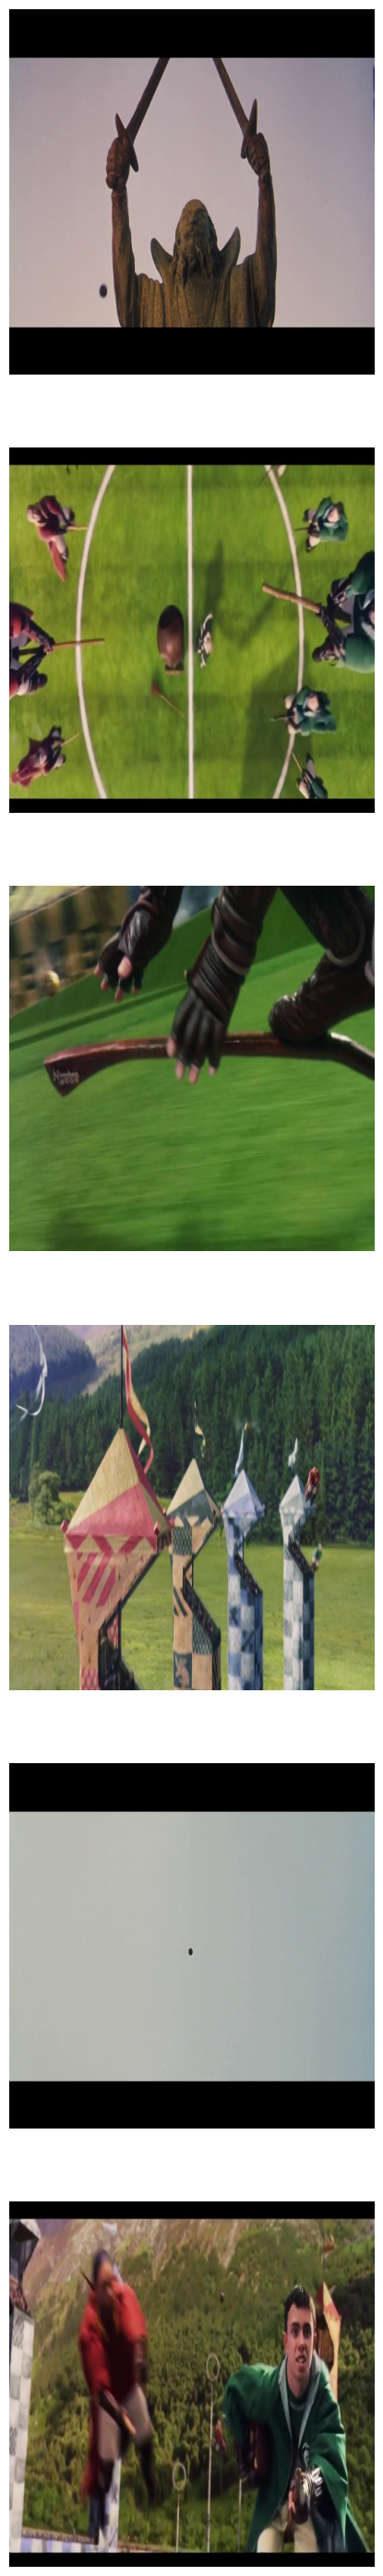

In [97]:
import matplotlib.patches as patches

def rescale_and_reformat(image):

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std[:, None, None]) + mean[:, None, None]
    image = np.clip(image, 0, 1)
    return image.transpose(1, 2, 0)

visualized_images = [rescale_and_reformat(img.numpy()) for img in test_images.cpu()]


def visualize_predictions(images, preds, threshold=0.1):
    decoded_preds = [decode_prediction(p, threshold=threshold) for p in preds]

    fig, axs = plt.subplots(len(images), 1, figsize=(12, len(images) * 6))

    if len(images) == 1:
        axs = [axs]

    for i, image in enumerate(images):
        ax = axs[i]
        ax.imshow(image)
        ax.axis('off')

        for bbox in decoded_preds[i]:
            if len(bbox) == 5:
                xmin, ymin, xmax, ymax, class_id = bbox
            else:
                print("Unexpected bbox format:", bbox)
                continue

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'Class: {class_id}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()


visualize_predictions(visualized_images, preds, threshold=0.1)


Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [93]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 9.9 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [94]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [98]:
def annotation2txt(bboxes, w_im, h_im):
    converted_annotations = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox
        x_center = ((xmin + xmax) / 2) / w_im
        y_center = ((ymin + ymax) / 2) / h_im
        width = (xmax - xmin) / w_im
        height = (ymax - ymin) / h_im
        converted_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return converted_annotations


In [101]:
for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [102]:
nc = len(train_ds.class_dict)
names = list(train_ds.class_dict.keys())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")


## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')

model.train(data='data.yaml')



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 9.61MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 57.2MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 283 images, 0 backgrounds, 0 corrupt: 100%|██████████| 283/283 [00:00<00:00, 2140.83it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 283 images, 0 backgrounds, 6 corrupt: 100%|██████████| 283/283 [00:00<00:00, 1615.30it/s]

val: WARNING ⚠️ /content/valid/images/102.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4164]
val: WARNING ⚠️ /content/valid/images/107.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3353]
val: WARNING ⚠️ /content/valid/images/186.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3038]
val: WARNING ⚠️ /content/valid/images/212.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1126]
val: WARNING ⚠️ /content/valid/images/223.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0435]
val: WARNING ⚠️ /content/valid/images/275.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4053]


val: New cache created: /content/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        10G      4.728      9.278      4.251         20        640: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        277        308   0.000132     0.0187   7.56e-05   2.46e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.99G       4.26      8.118      4.116         20        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        277        308   0.000173     0.0374   0.000109   2.67e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.99G      3.884      7.073      3.818         18        640: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]

                   all        277        308   0.000179     0.0373   0.000107   3.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.99G      3.483      6.687      3.457         17        640: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        277        308   8.26e-05     0.0186   8.17e-05   1.71e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.99G        3.2      6.193      3.155         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        277        308   8.22e-05     0.0186   6.53e-05   1.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.99G       3.02      5.724      2.954         14        640: 100%|██████████| 18/18 [00:07<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


                   all        277        308    8.9e-05     0.0186   5.93e-05   1.65e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.99G      2.876      5.228      2.708         21        640: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        277        308   0.000133     0.0205   8.21e-05   3.03e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.99G       2.74      4.752        2.6         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all        277        308      0.335     0.0346     0.0017   0.000548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.99G      2.662      4.447      2.532         25        640: 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]

                   all        277        308    0.00196      0.119    0.00151   0.000509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.01G      2.557      4.436      2.319         34        640: 100%|██████████| 18/18 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        277        308     0.0939     0.0744     0.0298     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.99G      2.639      4.171      2.381         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

                   all        277        308      0.445     0.0741     0.0773     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.99G       2.54      3.906      2.175         17        640: 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all        277        308      0.447      0.079     0.0725      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.99G      2.448      3.689      2.125         30        640: 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all        277        308      0.519     0.0992     0.0779     0.0273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.99G      2.422      3.497      2.049         24        640: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all        277        308      0.164      0.149      0.109     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.99G      2.473       3.52      2.116         28        640: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        277        308      0.252      0.144      0.129     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.01G      2.337      3.372      2.029         28        640: 100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

                   all        277        308      0.194      0.194      0.118     0.0371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.99G      2.314      3.319      2.046         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

                   all        277        308      0.174      0.147      0.104     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.99G      2.252      3.058      1.988         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all        277        308      0.143        0.2      0.136     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.99G      2.289      3.017      1.987         26        640: 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        277        308      0.209       0.16      0.128     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.99G      2.281      2.945      1.931         22        640: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        277        308      0.207      0.219      0.145     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.99G      2.162      2.805      1.842         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all        277        308      0.293        0.2      0.175     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.99G      2.184      2.825      1.858         25        640: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

                   all        277        308      0.293      0.213      0.194     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.99G       2.13      2.626      1.781         20        640: 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        277        308      0.276      0.238        0.2      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.99G      2.042      2.618      1.745         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]

                   all        277        308      0.274      0.251      0.234      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.99G      2.087      2.548      1.744         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all        277        308      0.317      0.309      0.243      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.99G      2.001      2.343      1.676         32        640: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all        277        308      0.383      0.324      0.284       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.99G      2.009      2.474       1.77         15        640: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        277        308      0.404      0.297      0.267      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.99G      1.926       2.22      1.716         24        640: 100%|██████████| 18/18 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all        277        308      0.399      0.348      0.305      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.99G      1.917      2.298      1.623         14        640: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all        277        308      0.375      0.272      0.265      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.99G      1.805      2.065      1.529         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


                   all        277        308      0.377      0.341      0.297      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.99G      1.765      1.946      1.555         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

                   all        277        308      0.454      0.325      0.343      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.99G      1.834      1.987      1.659         26        640: 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


                   all        277        308      0.483      0.329      0.334      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.99G      1.819      1.872      1.602         18        640: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

                   all        277        308      0.455      0.334       0.34      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.99G      1.812      1.963      1.572         26        640: 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        277        308      0.405      0.377      0.353      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.99G      1.799      1.867      1.545         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all        277        308      0.481      0.338      0.342      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.99G      1.702      1.822      1.452         20        640: 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        277        308       0.44      0.348       0.34      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.99G      1.726      1.887      1.552         22        640: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]

                   all        277        308      0.484      0.308      0.346      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.99G      1.798      1.887      1.606         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


                   all        277        308      0.443      0.387      0.371      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.99G      1.754      1.821        1.5         26        640: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all        277        308      0.441      0.398       0.38      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.99G      1.709      1.741      1.552         24        640: 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

                   all        277        308      0.484      0.392      0.387      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.99G      1.712      1.721      1.534         15        640: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.08it/s]

                   all        277        308      0.445      0.376       0.38      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.99G      1.726      1.678      1.508         32        640: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

                   all        277        308       0.47      0.419      0.397      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.99G      1.671      1.692      1.473         33        640: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all        277        308      0.497       0.41      0.409      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.99G      1.664      1.568      1.471         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]

                   all        277        308      0.503      0.383       0.39      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.99G      1.703       1.58      1.449         29        640: 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all        277        308      0.455      0.424      0.415      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.99G      1.681      1.653      1.471         22        640: 100%|██████████| 18/18 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all        277        308      0.486      0.378      0.392      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.99G      1.665      1.663      1.458         30        640: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        277        308      0.488      0.418      0.408      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.99G      1.656      1.613      1.429         22        640: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

                   all        277        308      0.466      0.494      0.441      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.99G      1.682      1.543      1.484         26        640: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

                   all        277        308      0.544      0.447      0.465      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.99G      1.579      1.489      1.418         19        640: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all        277        308      0.463      0.439      0.429      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.99G      1.586       1.49      1.429         23        640: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        277        308      0.598      0.412      0.472      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.99G       1.63      1.485       1.48         22        640: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all        277        308      0.452      0.468      0.431      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.99G      1.632      1.431      1.436         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

                   all        277        308      0.485      0.482      0.452      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.99G      1.576      1.488      1.391         23        640: 100%|██████████| 18/18 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        277        308       0.44      0.458      0.411      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.99G      1.562      1.395       1.36         26        640: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all        277        308      0.509      0.478      0.491      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.99G      1.488      1.417      1.387         17        640: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all        277        308      0.546      0.489      0.483      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.99G      1.517      1.376      1.352         17        640: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]

                   all        277        308      0.574      0.419      0.474      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.99G       1.47      1.365      1.353         26        640: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


                   all        277        308      0.629      0.414      0.501      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.99G      1.461      1.323      1.361         24        640: 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all        277        308      0.525      0.491      0.502      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.99G      1.544      1.397      1.379         23        640: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all        277        308      0.589      0.485      0.499      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.99G       1.48       1.28      1.365         24        640: 100%|██████████| 18/18 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all        277        308      0.593      0.511      0.504      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.99G      1.451      1.304      1.349         27        640: 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all        277        308      0.549      0.517      0.506      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.99G      1.438        1.3      1.301         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

                   all        277        308      0.587      0.487      0.506      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.99G      1.497      1.243      1.376         27        640: 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all        277        308      0.584      0.524      0.522      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.99G      1.403      1.232      1.323         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all        277        308      0.604      0.524      0.525      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.99G      1.425       1.24      1.298         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        277        308      0.575      0.517      0.505      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.99G      1.442      1.206      1.326         16        640: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        277        308      0.587      0.521      0.513      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.99G      1.434      1.236      1.328         31        640: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all        277        308       0.62      0.518      0.526      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.99G      1.372      1.165      1.279         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        277        308      0.562       0.52      0.503      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.99G      1.442      1.225      1.306         19        640: 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


                   all        277        308      0.635       0.52      0.517      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.99G      1.421      1.157      1.292         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all        277        308      0.642      0.509      0.528      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.99G      1.496      1.198      1.389         28        640: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        277        308      0.562      0.558       0.53      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.99G       1.39      1.178      1.336         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

                   all        277        308      0.616      0.544      0.533      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.99G      1.393      1.194      1.271         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        277        308      0.646      0.523       0.54      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.99G      1.349      1.091      1.278         22        640: 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        277        308      0.614      0.543      0.543      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.99G      1.363      1.125      1.315         18        640: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all        277        308      0.629      0.551      0.553       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.99G       1.39       1.13      1.294         13        640: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all        277        308       0.63      0.557      0.544      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.99G      1.319      1.019       1.26         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        277        308       0.55      0.557      0.521      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.99G      1.353      1.067       1.25         22        640: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all        277        308      0.608      0.563      0.535      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.99G      1.317      1.059      1.233         19        640: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all        277        308      0.616      0.553      0.536      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.99G      1.306      1.034      1.236         28        640: 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]

                   all        277        308      0.642      0.536      0.537      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.99G      1.379      1.098      1.259         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        277        308      0.648      0.559      0.551      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.01G        1.3      1.046       1.24         21        640: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        277        308      0.645      0.555       0.55      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.85G       1.28     0.9803      1.244         42        640:  89%|████████▉ | 16/18 [00:06<00:00,  2.72it/s]

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


0: 640x640 1 bludger, 1: 640x640 1 quaffle, 2: 640x640 1 snitch, 3: 640x640 (no detections), 4: 640x640 1 quaffle, 5: 640x640 1 quaffle, 1 bludger, 6: 640x640 1 snitch, 7: 640x640 1 snitch, 8: 640x640 1 snitch, 9: 640x640 2 quaffles, 48.2ms
Speed: 4.4ms preprocess, 4.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


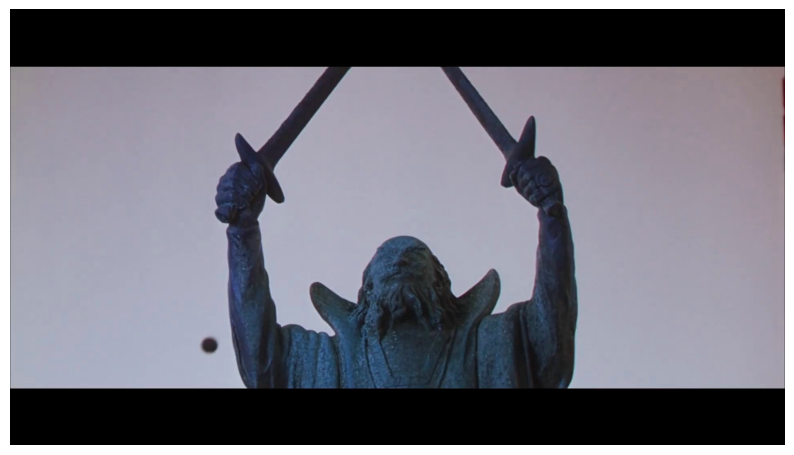

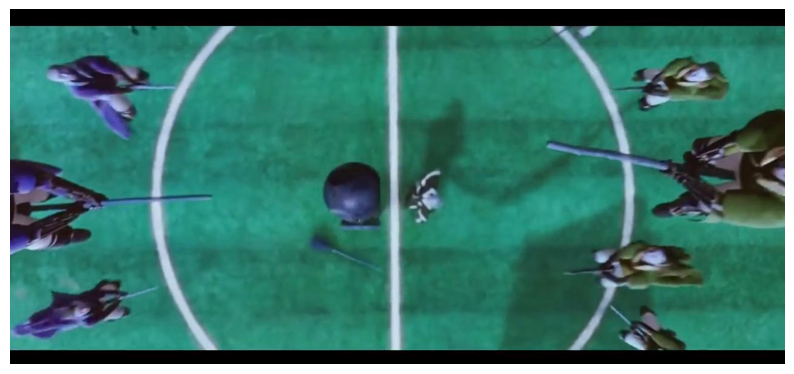

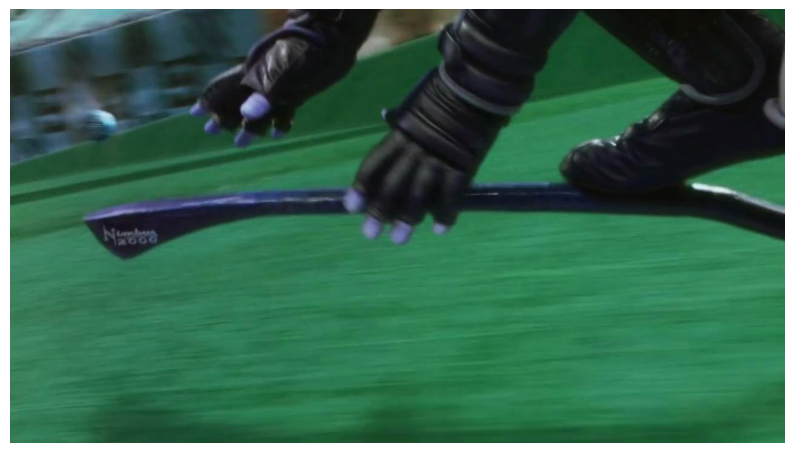

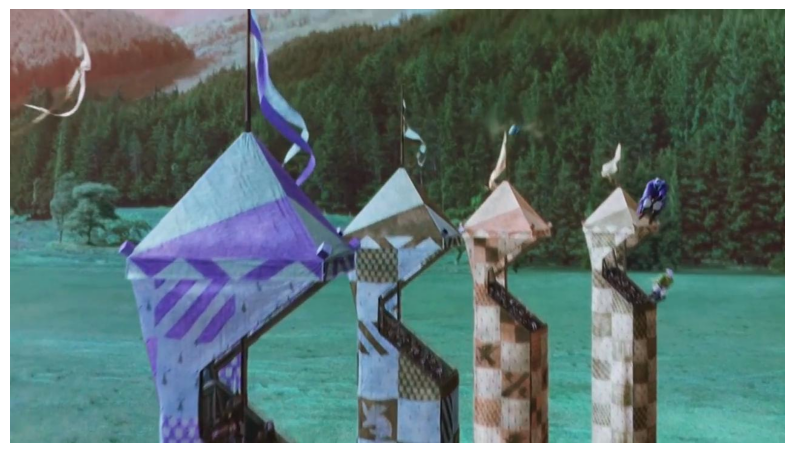

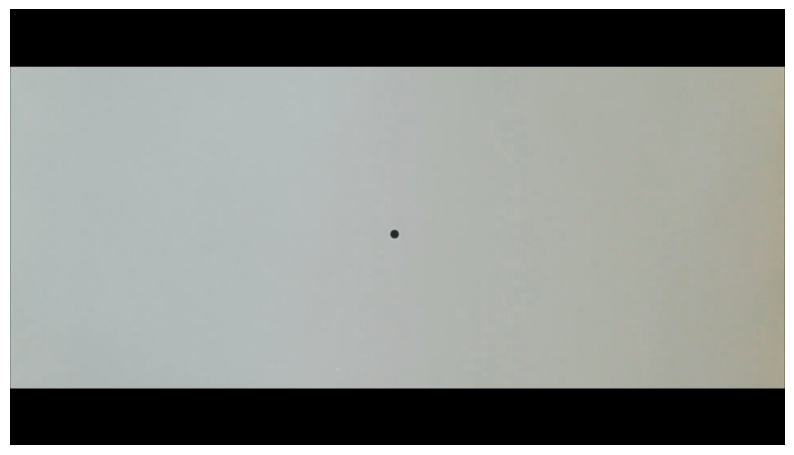

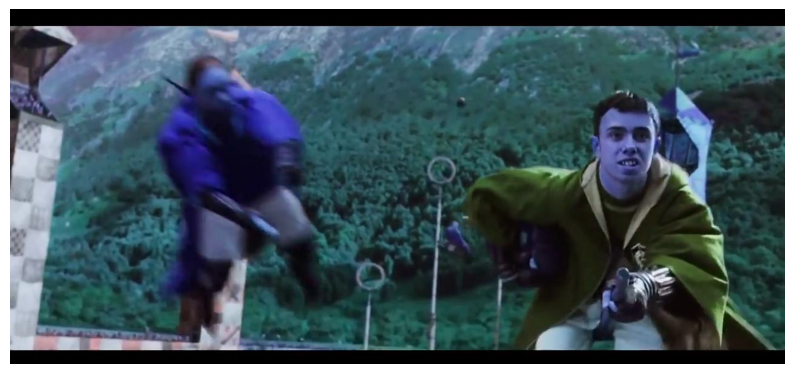

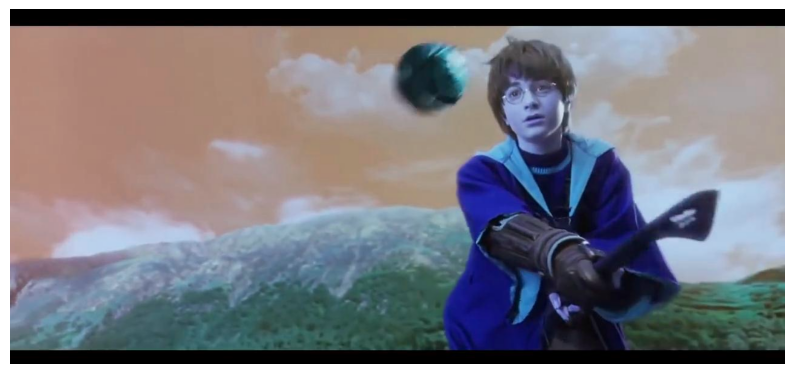

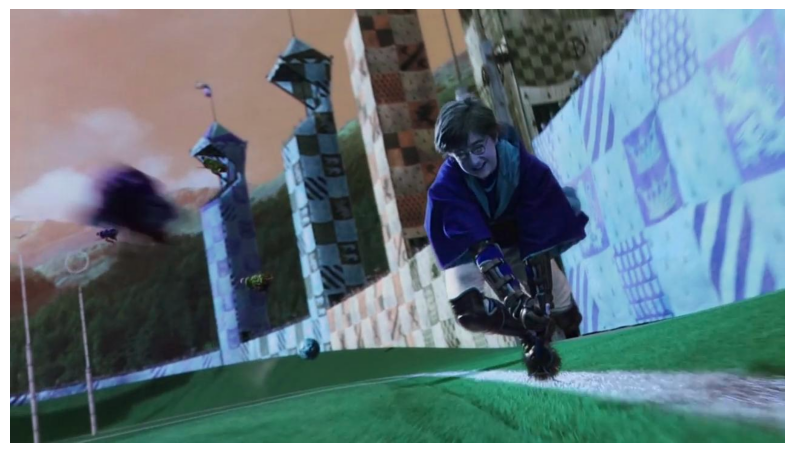

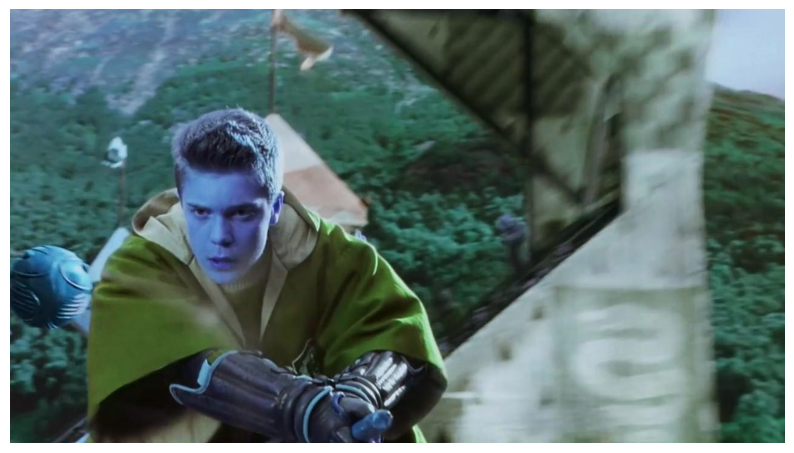

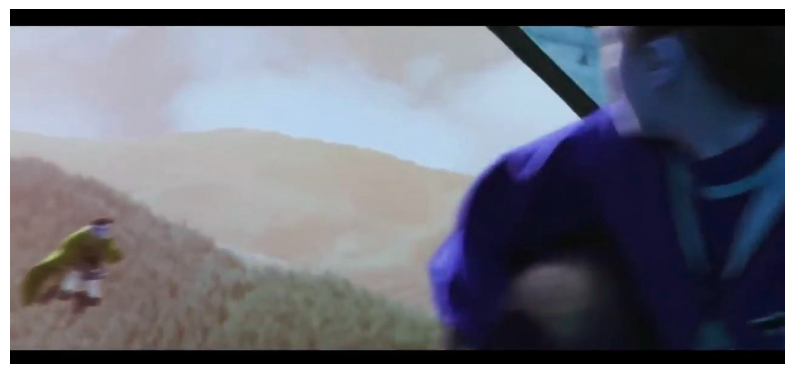

In [111]:
import os
valid_images = ['./valid/images/' + filename for filename in os.listdir('./valid/images')][:num_samples_to_visualize]

predictions = model.predict(valid_images)


for result in predictions:
    img = result.orig_img
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    if result.boxes is not None:
        for box in result.boxes:
            if len(box) >= 6:
                xmin, ymin, xmax, ymax, conf, class_id = box[:6]
                width, height = xmax - xmin, ymax - ymin
                rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                if result.names:
                    class_name = result.names[int(class_id)]
                    plt.text(xmin, ymin, f'{class_name} {conf:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

